#  __Using <font color=blue><a href=https://mlbi-lab.net>SCODA</a></font> for Single-cell RNA-seq data analysis and mining__

- This Jupyter notebook provides example code for visualizing and mining the results processed by <a href=https://mlbi-lab.net>__SCODA__</a>, a single-cell RNA-seq data analysis pipeline developed by __MLBI Lab__.
- Data mining is conducted using the __SCODA-viz__ package and includes the following components:

<br>

1. <font color=blue>Review of cell type annotation results</font>
   - Preprocessing for visualization and generation of UMAP coordinates
   - Visualization of celltype marker expression patterns
   - Examination of cell type populations and identification of condition-specific features
2. <font color=blue>Review of CNV and tumor cell identification results</font>
   - Visualization of CNV patterns via heatmap
   - Tumor cell identification confirmed via UMAP projection
3. <font color=blue>Profiling of ligand–receptor interactions between cell types</font>
  - Structure and composition of CCI result data
  - Visualization using dot plots and circle plots
  - Statistical testing of condition-specific interactions and visualization via boxplots
4. <font color=blue>Differential expression analysis and marker/target discovery</font>
  - Structure of DEG result data
  - Inspection of DEG results
  - Marker/target discovery and visualization using dot plots
5. <font color=blue>Gene set analysis (GSA) and interpretation of enrichment results</font>
  - Structure of GSA/GSEA output data
  - Visualization of GSA/GSEA results using barplots
  - Visualization of GSA/GSEA results using dotplots

6. <font color=firebrick>Auxiliary analysis using cancer genomics big data</font> (e.g., METABRIC or TCGA data)
7. <font color=firebrick>Visualization of pathway-level changes using KEGG Pathview</font> (provided in a separate notebook using R)

<br>

__MLBI-lab, July 27, 2025__

contact: mlbi@mlbi-lab.com




## __1. Install required packages and import them__

In [ ]:
## 필요한 패키지 설치 (이미 설치되었다면 skip 해도 됩니다.)
'''
!pip install gdown
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install scikit-network
!pip install statannot
!pip install statannotations
!pip install lifelines
!pip install plotly
'''
!pip install scanpy
!pip install scoda-viz --upgrade

In [2]:
## 필요한 패키지 불러오기
import copy, warnings, os
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from scodaviz import plot_population, plot_population_grouped
from scodaviz import plot_cci_dot, plot_cci_circ_group
from scodaviz import plot_gsa_bar, plot_gsa_dot
from scodaviz import plot_deg, plot_marker_exp
from scodaviz import plot_cnv, plot_violin, plot_pct_box
from scodaviz import get_sample_to_group_map, plot_sankey

from scodaviz import get_population, get_cci_means, get_gene_expression_mean
from scodaviz import get_markers_from_deg, test_group_diff, filter_gsa_result
from scodaviz import find_condition_specific_markers, find_genomic_spots_of_cnv_peaks
from scodaviz import load_scoda_processed_sample_data, get_abbreviations

warnings.filterwarnings('ignore')

https://github.com/combio-dku
INFO: statannotations was sucessfully installed.


## __2A. Download a preprocessed data__

In [3]:
dataset = 'Colitis-mm'  ## You can choose one of ['BC', 'NSCLC', 'PDAC', 'CRC', 'Colitis-mm', 'Colitis-hs']
adata_t = load_scoda_processed_sample_data( dataset )
adata_t

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1QgdmySeTYQjW0NfNxbpaokU22VpEpcHA
From (redirected): https://drive.google.com/uc?export=download&id=1QgdmySeTYQjW0NfNxbpaokU22VpEpcHA&confirm=t&uuid=5382495a-fed9-4108-b02c-b47be5d0c305
To: /content/downloaded
100%|██████████| 226M/226M [00:01<00:00, 135MB/s]


File saved to: colon_mm_GSE264408_39K_scoda_250728.h5ad


AnnData object with n_obs × n_vars = 38900 × 20582
    obs: 'sample', 'condition', 'sample_ext', 'celltype_major', 'celltype_minor', 'celltype_subset', 'celltype_for_cci'
    var: 'gene_ids', 'feature_types', 'variable_genes'
    uns: 'CCI', 'CCI_sample', 'Celltype_marker_DB', 'DEG', 'DEG_grouping_vars', 'DEG_stat', 'DEG_vs_ref', 'DEG_vs_ref_stat', 'GSA_down', 'GSA_up', 'GSA_vs_ref_down', 'GSA_vs_ref_up', 'GSEA', 'GSEA_vs_ref', 'HiCAT_summary', 'Pathways_DB', 'analysis_parameters', 'log', 'lut_sample_to_cond', 'usr_param'
    obsm: 'HiCAT_result', 'X_pca'

## __2B. Or, load your h5ad file__
데이터를 불러오려면 호스팅 된 Colab 서버에 h5ad파일을 직접 업로드하거나 본인 계정의 구글 드라이브를 마운트하여 가져올 수 있습니다.

In [ ]:
file_h5ad = 'colon_mm_GSE264408_39K_scoda_250728.h5ad'

In [ ]:
adata_t = sc.read_h5ad(file_h5ad)
adata_t

AnnData object with n_obs × n_vars = 38900 × 20582
    obs: 'sample', 'condition', 'sample_ext', 'celltype_major', 'celltype_minor', 'celltype_subset', 'celltype_for_cci'
    var: 'gene_ids', 'feature_types', 'variable_genes'
    uns: 'CCI', 'CCI_sample', 'Celltype_marker_DB', 'DEG', 'DEG_grouping_vars', 'DEG_stat', 'DEG_vs_ref', 'DEG_vs_ref_stat', 'GSA_down', 'GSA_up', 'GSA_vs_ref_down', 'GSA_vs_ref_up', 'GSEA', 'GSEA_vs_ref', 'HiCAT_summary', 'Pathways_DB', 'analysis_parameters', 'log', 'lut_sample_to_cond', 'usr_param'
    obsm: 'HiCAT_result', 'X_pca'

## __3. Check your SCODA-processed data__

#### __AnnData Format__
  
<div>
<img src="https://drive.google.com/uc?export=view&id=1IGjZpO_DeaNFiX3u_fy_rnPC1oKwVsqU" align="center" width="500"/>
</div>
<div>
<img src="attachment:fefeae20-ad05-4cea-8327-72f3dd19903f.png" width="500"/>
</div>

https://anndata.readthedocs.io/en/stable/

#### __Basic operations__
1. cell selection, gene selection (supports boolean indexing as for DataFrame)
3. writing to a file
4. getting cell-by-gene count matrix as a data frame
5. adding an annotation

In [ ]:
adata_t

In [ ]:
adata_t.obs.head()

In [ ]:
## Cell-selection example
b = adata_t.obs['celltype_major'] == 'Epithelial cell'
adata = adata_t[b,:]
adata

In [ ]:
adata.obs['sample'].value_counts()

In [ ]:
## Example: writing anndata to a file
adata.write('Epi_only.h5ad')

In [ ]:
## Example: getting cell-by-gene count matrix as a data frame
X_full = adata.to_df()
X_full.head()

-  #### SCODA를 이용하여 생성된 결과
    - __적용된 분석 파라미터__: adata_t.uns['analysis_parameters']
    - __celltype annotation 결과__: adata_t.obs[['celltype_major', 'celltype_minor', 'celltype_subset']]
    - __celltype annotation 결과의 상세내용__: adata_t.obsm['HiCAT_result']
    - __celltype annotation에 사용된 celltype marker 정보__: adata_t.uns['Celltype_marker_DB']
    - __InferCNV 결과__: adata_t.obsm['X_cnv'], adata_t.obsm['X_cnv_pca'], adata_t.obs[['cnv_score', 'cnv_cluster']]
    - __InferCNV 분석 파라미터 및 관련 정보__: adata_t.uns['cnv'], adata_t.uns['cnv_neighbors_info'], adata_t.uns['cnv_ref_celltypes']
    - __InferPloidy 결과__: adata_t.obs[['ploidy_dec', 'ploidy_score']
    - __Cell간 상호작용 추론 결과__: adata_t.uns['CCI_sample'] (샘플별), adata_t.uns['CCI'] (조건별)
    - __DEG 결과__: adata_t.uns['DEG'], adata_t.uns['DEG_stat']
    - __GSA/GSEA 결과__: adata_t.uns['GSA_down'], adata_t.uns['GSA_up'], adata_t.uns['GSEA']

In [ ]:
adata_t.obs[['sample', 'condition']].value_counts()

In [ ]:
lst = [adata_t.obs['condition'], adata_t.obs['sample']]
plot_sankey(lst, title=None, fs=12, WH=(400, 400), th=30, title_y=0.85 )

In [ ]:
lst = [adata_t.obs['celltype_subset'], adata_t.obs['celltype_minor'], adata_t.obs['celltype_major']]
plot_sankey(lst, title=None, fs=12, WH=(700, 800), th=30, title_y=0.85 )

In [ ]:
adata_t.obs['celltype_major'].value_counts()

In [ ]:
adata_t.obs['celltype_minor'].value_counts()

In [ ]:
adata_t.uns['analysis_parameters']

In [ ]:
adata_t.obsm['HiCAT_result']

## __4. Explore your data__
A. <font color=blue>세포유형 식별결과 확인</font>
   - 시각화를 위한 기본 처리 및 UMAP 좌표 생성
   - 세포유형 마커 발현 패턴 확인
   - 세포유형 population 확인 및 조건특이적 특징 판별

B. <font color=blue>CNV 및 암세포 식별 결과 확인</font>
   - CNV heatmap 확인
   - UMAP을 통한 암세포 식별 결과 확인

C. <font color=blue>세포유형간 ligand-receptor 상호작용 프로파일</font>
   - 결과 데이터의 구성
   - dot plot 및 circle plot을 이용한 확인
   - 조건-특이적 상호작용의 통계적 검정 및 boxplot을 이용한 확인   

D. <font color=blue>DEG 분석 결과 및 마커/표적 탐색</font>
   - DEG 결과 데이터의 구성
   - DEG 결과의 확인
   - 마커/표적 탐색 및 dotplot을 이용한 확인

E. <font color=blue>유전자 집합 분석(Gene Set Analysis) 결과 확인</font>
  - GSA/GSEA 결과 데이터의 구성
  - barplot을 이용한 GSA/GSEA 결과의 확인
  - dotplot을 이용한 GSA/GSEA 결과의 확인

F. <font color=firebrick>암유전체 빅데이터의 보조적 활용</font>

G. <font color=firebrick>KEGG pathview 생성하여 pathway상의 변화 확인</font> (별도의 주피터 노트북 제공)

In [4]:
## Retreive celltype abbreviations
rename_dict = get_abbreviations()

## Retreive same to condition mapping
sample_group_map = adata_t.uns['lut_sample_to_cond']

### __A.1 Basic preprocessing for UMAP projection__

In [5]:
## adata_t의 사본을 만들어서 adata에 저장
adata = adata_t[:,:]
## 이렇게하면 adata에 대해 처리한 내용이 원본에는 반영되지 않음

## UMAP 프로젝션을 얻기 위한 기본적 처리과정
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
sc.tl.pca(adata, n_comps = 15, use_highly_variable = True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15, use_rep = 'X_pca')
sc.tl.umap(adata)

### __A.2 An overview of celltype annotation result__

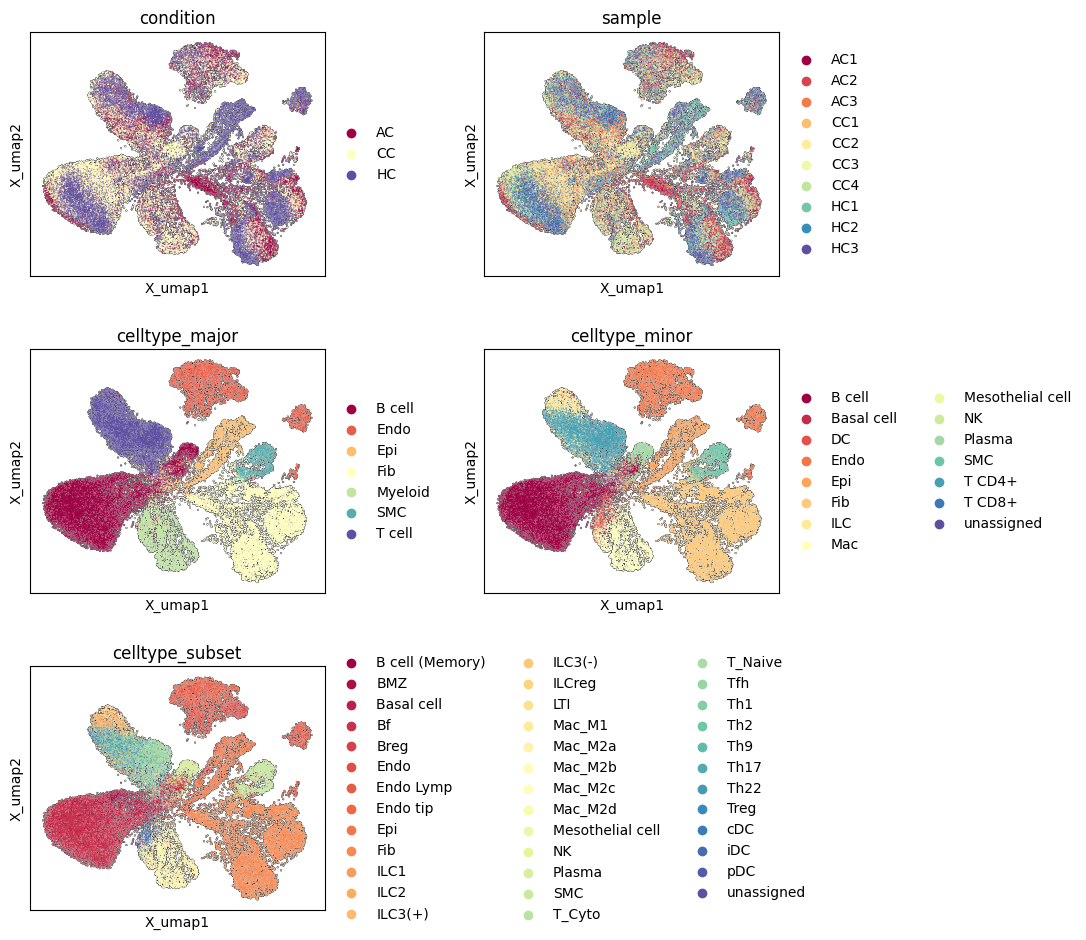

In [ ]:
items_to_plot = ['condition', 'sample',
                 'celltype_major', 'celltype_minor', 'celltype_subset']

## Abbreviate cell names
cols = ['celltype_major', 'celltype_minor', 'celltype_subset']
for col in cols:
    adata.obs[col] = adata.obs[col].astype(str)
    adata.obs[col].replace(rename_dict[col], inplace = True)

plt.rcParams['figure.figsize'] = (3.5, 3.5)
sc.pl.embedding( adata, basis = 'X_umap', neighbors_key = 'neighbors',
                 color=items_to_plot, wspace = 0.4, hspace = 0.3, legend_fontsize = 10,
                 ncols = 2, palette = 'Spectral', add_outline = True)

- __HiCAT:__ https://github.com/combio-dku/HiCAT

### __A.3 Inspecting minor-type annotation result__

In [ ]:
adata.obs['celltype_minor'].value_counts()

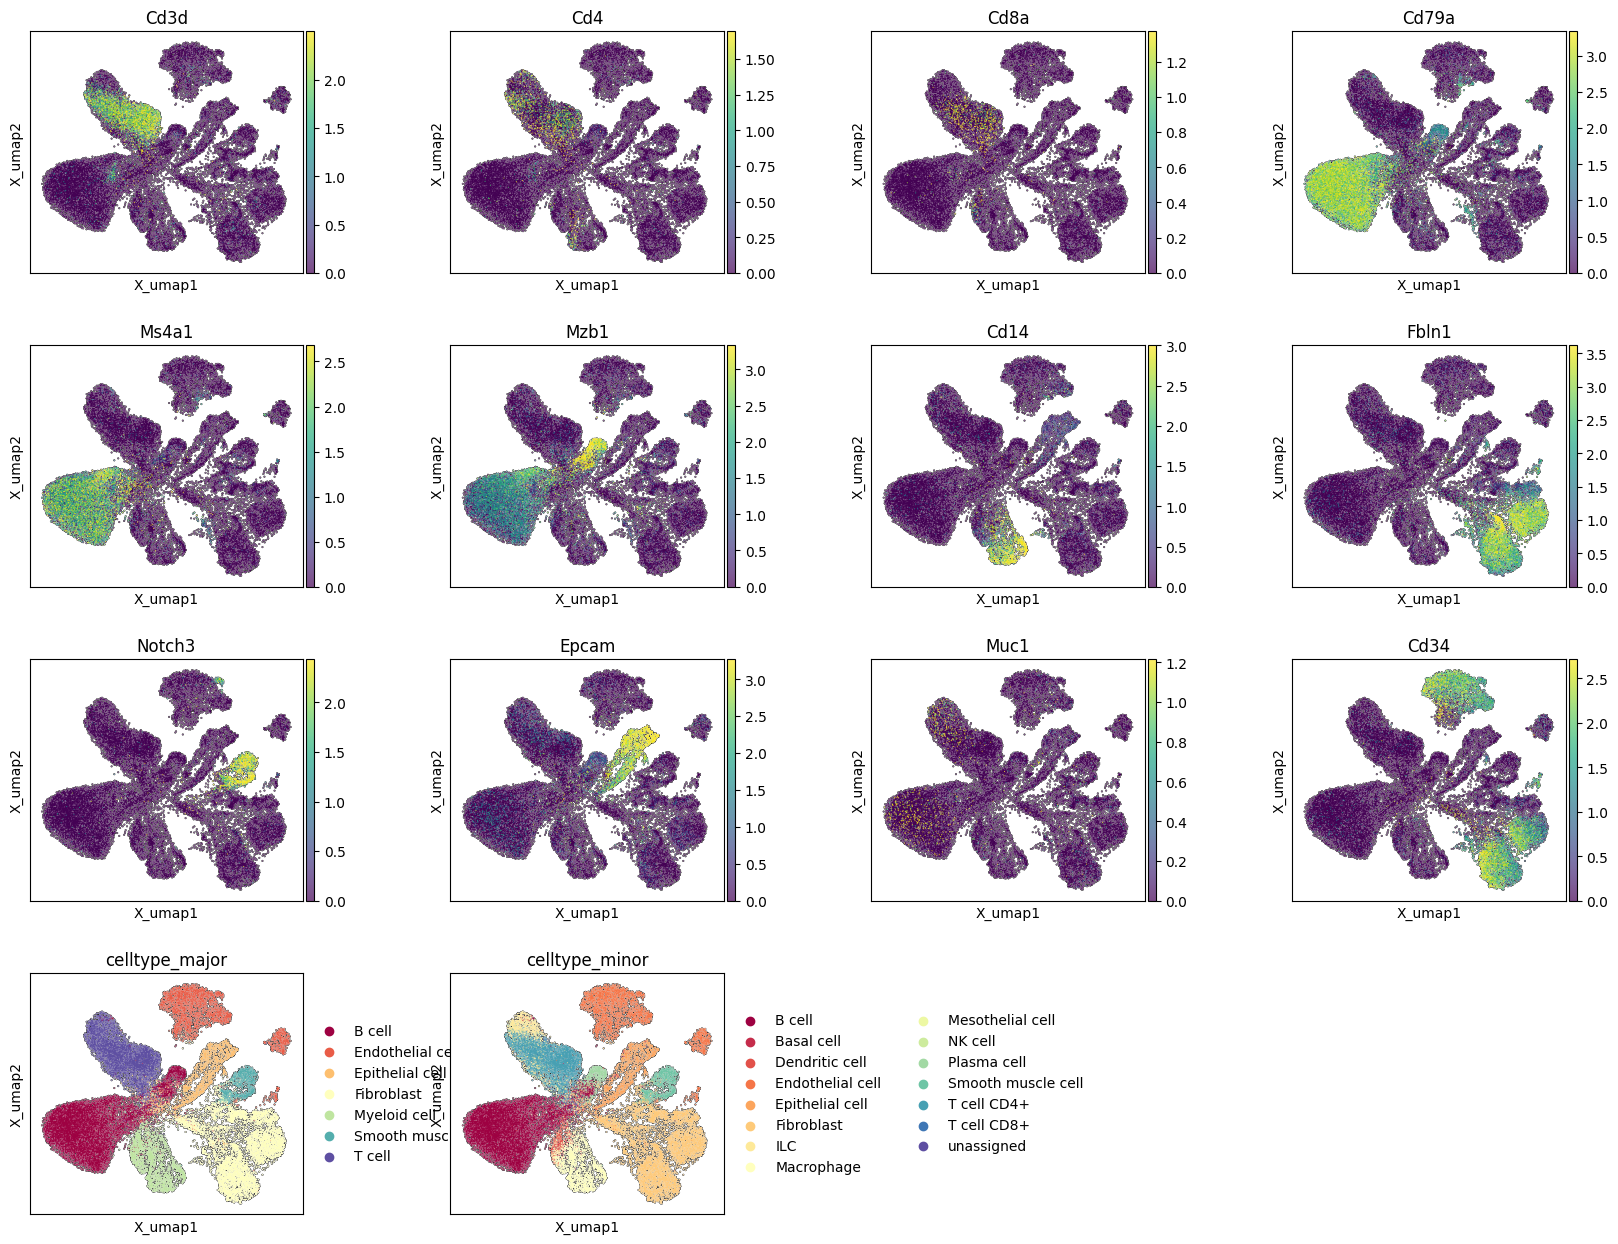

In [7]:
items_to_plot = ['celltype_major', 'celltype_minor']

if adata_t.uns['usr_param']['species'] == 'human':
    genes = ['CD3D', 'CD4', 'CD8A', 'CD79A', 'MS4A1', 'MZB1',
             'CD14', 'LYZ', 'FBLN1', 'NOTCH3', 'EPCAM', 'MUC1',  'CD34']
else:
    genes = ['Cd3d', 'Cd4', 'Cd8a', 'Cd79a', 'Ms4a1', 'Mzb1',
             'Cd14', 'Lyz', 'Fbln1', 'Notch3', 'Epcam', 'Muc1',  'Cd34']

## 위 목록의 마커 유전자들 중 현재의 데이터에 있는 유전자들만 순서대로 선택
genes_all = list(adata.var.index.values)
items_to_plot = [g for g in genes if g in genes_all] + items_to_plot

plt.rcParams['figure.figsize'] = (3.5, 3.5)
sc.pl.embedding( adata, basis = 'X_umap', neighbors_key = 'neighbors',
                 color=items_to_plot, wspace = 0.4, hspace = 0.3,
                 legend_fontsize = 10,ncols = 4, palette = 'Spectral',
                 add_outline = True, vmax = 'p99', vmin = 0)

#### __A.4 Subset marker expression profile__
- Subset annotation은 UMAP으로 확인하기 어려우므로 dot plot을 사용하여 확인
- dot의 크기는 annotation 결과 기준으로 해당 유형의 세포 중 얼마나 많은 비율이 해당 유정의 마커 유전자를 발현하고 있는지 보여줌


Num markers selected: 162 -> 120


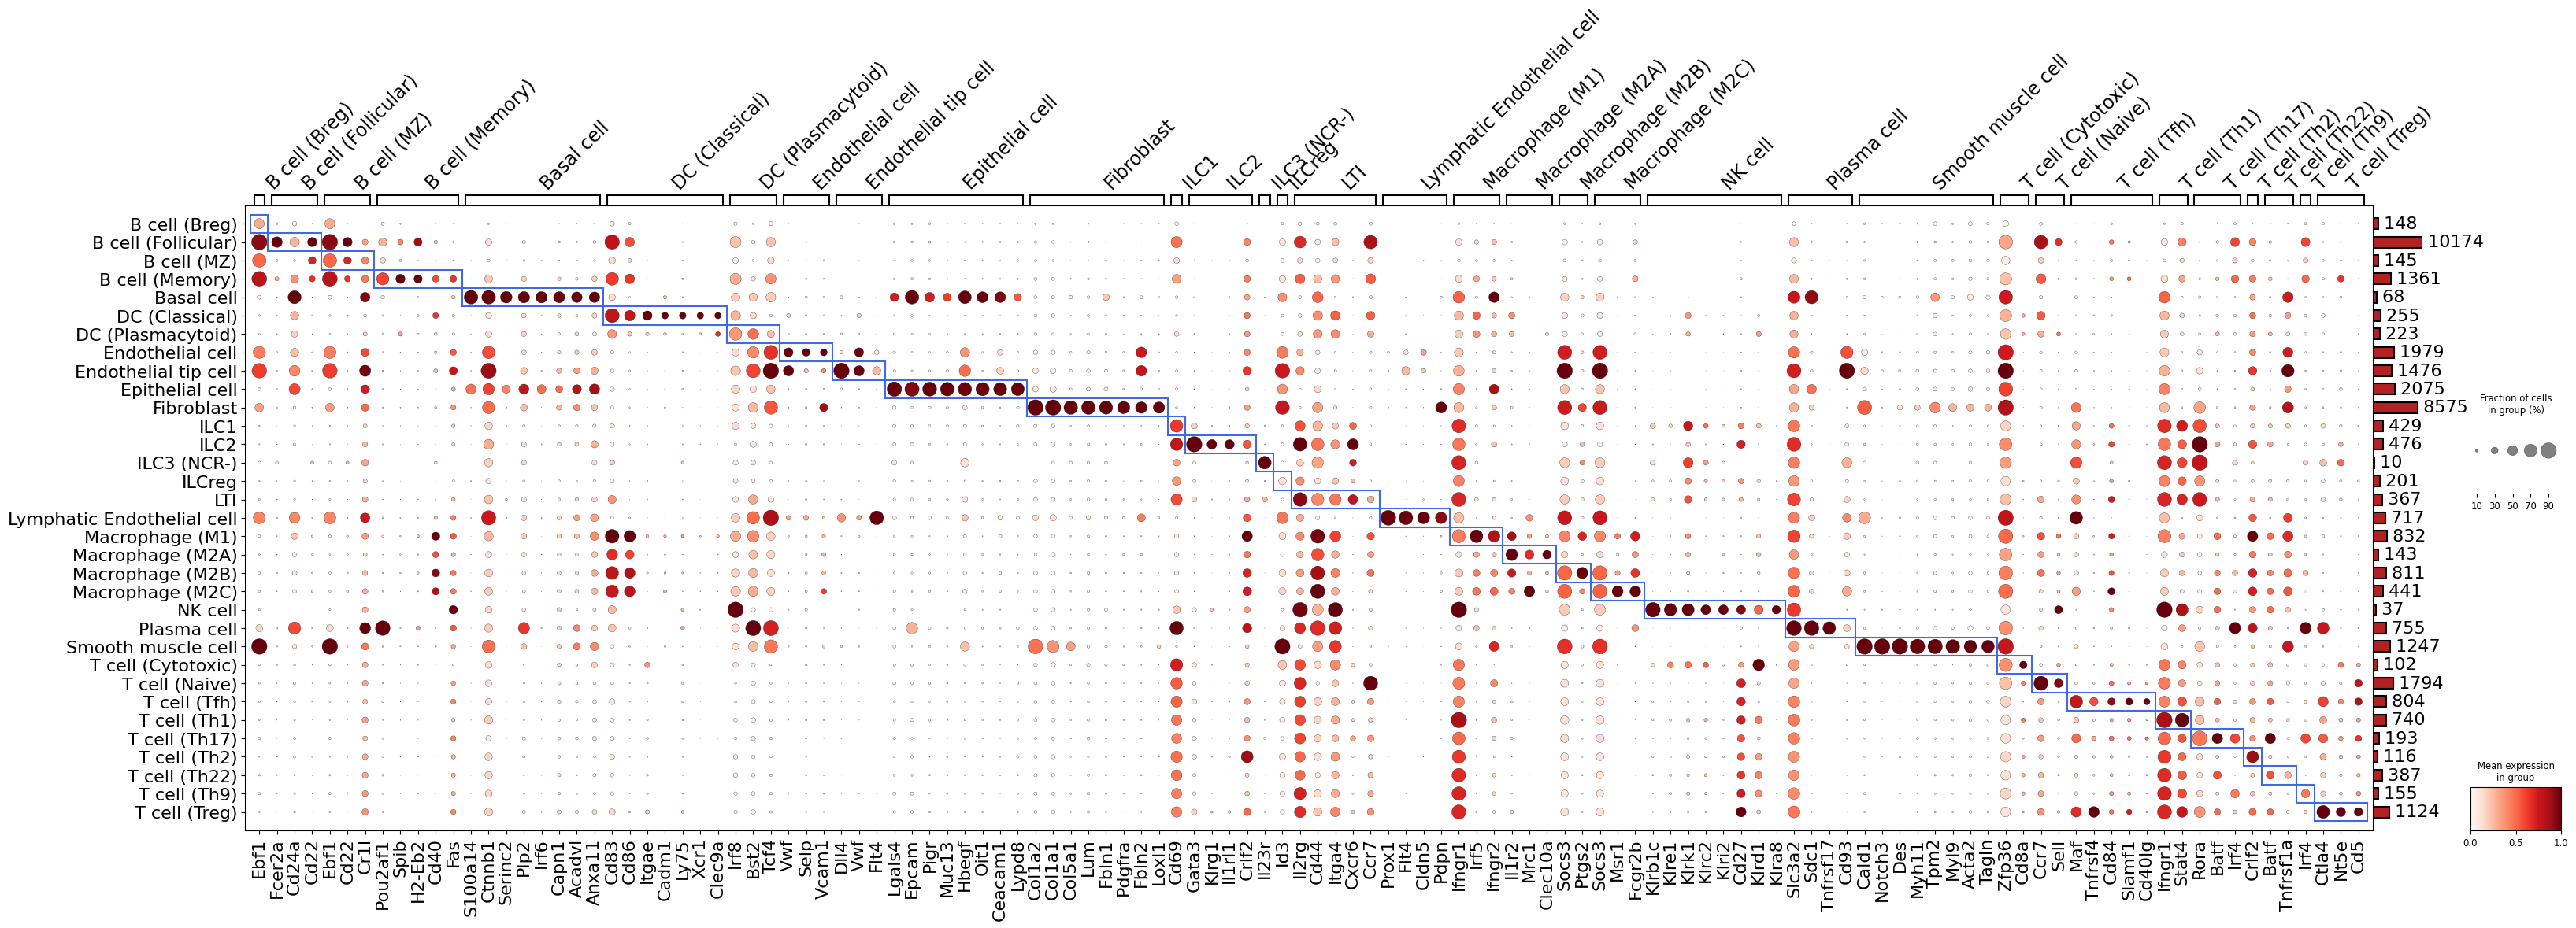

In [ ]:
plot_marker_exp(  adata_t, markers = None,
                  N_cells_per_group_min = 10, N_markers_per_group_max = 8, N_markers_total = 120,
                  title = None, title_y_pos = 1.1, title_fs = 30,
                  text_fs = 16, linewidth = 1.5, standard_scale = 'var',
                  var_group_rotation = 45, var_group_height = 1.2,
                  nz_frac_max = 0.9, nz_frac_cutoff = 0.05,
                  rem_mkrs_common_in_N_groups_or_more = 3,
                  figsize = None, swap_ax = False, legend = True )

### __Practice:__ Visualizing T-cell subsets

In [ ]:
b = adata_t.obs['celltype_major'] == 'Myeloid cell'
adata = adata_t[b,:]

## UMAP 프로젝션을 얻기 위한 기본적 처리과정
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes = 1000)
sc.tl.pca(adata, n_comps = 15, use_highly_variable = True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15, use_rep = 'X_pca')
sc.tl.umap(adata)

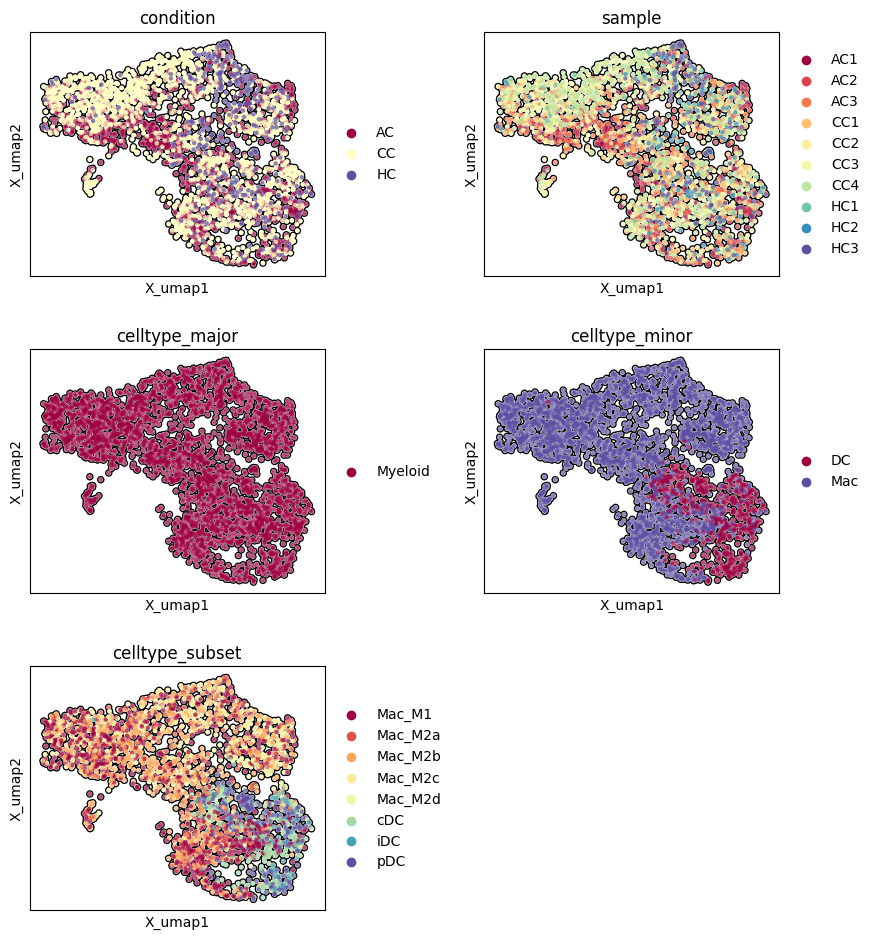

In [ ]:
items_to_plot = ['condition', 'sample',
                 'celltype_major', 'celltype_minor', 'celltype_subset']

cols = ['celltype_major', 'celltype_minor', 'celltype_subset']
for col in cols:
    adata.obs[col] = adata.obs[col].astype(str)
    adata.obs[col].replace(rename_dict[col], inplace = True)

plt.rcParams['figure.figsize'] = (3.5, 3.5)
sc.pl.embedding( adata, basis = 'X_umap', neighbors_key = 'neighbors',
                 color=items_to_plot, wspace = 0.4, hspace = 0.3, legend_fontsize = 10,
                 ncols = 2, palette = 'Spectral', add_outline = True)

### __A.5 Inspecting celltype population__


In [ ]:
## 샘플별 세포 개수 및  상대비율을 얻어서 데이터프레임에 저장
celltype_col = 'celltype_minor' ## 세포 유형의 기준
df_cnt, df_pct= get_population( adata_t.obs['sample_ext'],
                                adata_t.obs[celltype_col], sort_by = [] )
## 샘플별 세포 개수 확인
display(df_pct.round(1))

plot_population( df_pct, bar_width = 0.6,
                 title = celltype_col, title_fs = 14,
                 label_fs = 12, tick_fs = 10, xtick_rot = 45, xtick_ha = 'right',
                 legend_fs = 9, legend_loc = 'center left', bbox_to_anchor = (1,0.5),
                 legend_ncol = 1, cmap_name = None, figsize=(6, 2), dpi = 100)

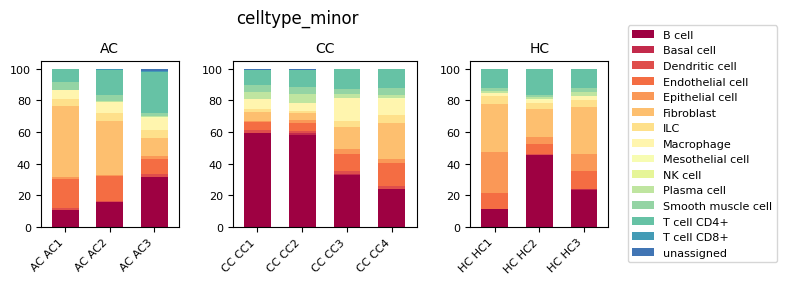

In [ ]:
## 샘플별 세포 개수 및  상대비율을 얻어서 데이터프레임에 저장
celltype_col = 'celltype_minor' ## 세포 유형의 기준
df_cnt, df_pct= get_population( adata_t.obs['sample_ext'],
                                adata_t.obs[celltype_col], sort_by = [] )

plot_population_grouped( df_pct, sample_group_map, sort_by = [], bar_width = 0.6,
                         title = celltype_col, title_fs = 12, title_y_pos = 1.2,
                         label_fs = 10, tick_fs = 8, xtick_rot = 45, xtick_ha = 'right',
                         legend_fs = 8, legend_loc = 'center left', bbox_to_anchor = (1.1,0.5),
                         legend_ncol = 1, cmap_name = None, figsize=(7, 2), dpi = 100,
                         wspace = 0.35, hspace = 0.2 )

### __A.6 Inspecting condition-specificity in celltype population__

In [ ]:
## 요부분은 sample 별 population을 얻어 조건별로 population이 유의하게
## 차이가 나는지 확인하는 부분입니다.
## 따라서, condition 당 sample이 최소 2개 이상 있는 경우 결과가 나오고
## sample이 많을 수록 통계적 유의성이 커짐 (p-value가 작아짐)

df_res = test_group_diff( df_pct, sample_group_map, ref_group = 'HC', pval_cutoff = 0.8 )
display(df_res)

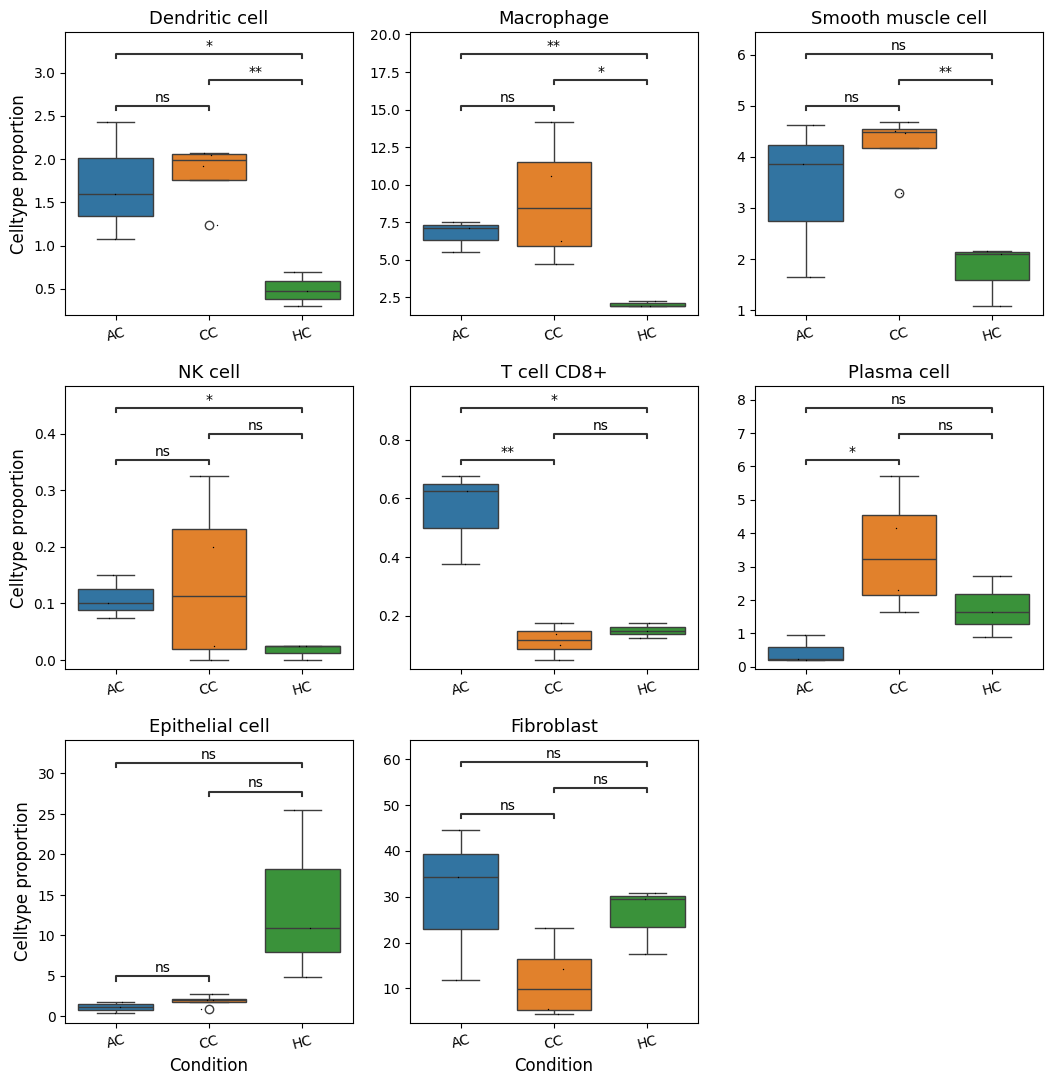

In [ ]:
## 표시할 결과 항목을 선택: 최대 8개만
max_n_items_to_plot = 8
idx_sel = df_res.index.values.tolist()[:min(max_n_items_to_plot, df_res.shape[0])]

if len(idx_sel) > 0:
    ## Show the first 5 CCIs
    plot_pct_box(df_pct[idx_sel], sample_group_map, ylabel = 'Celltype proportion',
                 ncols = 3, figsize = (3.5,3.5), dpi = 100,
                 group_order = None, # ['Normal', 'ER+', 'HER2+', 'TNBC'],
                 title = None, title_y_pos = 1.05, title_fs = 15,
                 label_fs = 12, tick_fs = 10, xtick_rot = 15,
                 annot_ref = None, annot_fmt = 'star', annot_fs = 10,
                 ws_hs = (0.2, 0.25), stripplot = True, cmap = 'tab10')

#### __Practice: Inspecting subset population__

Macrophage (M1) Macrophage (M2A) Macrophage (M2B) Macrophage (M2C)  \
AC AC1              82               12               88               20   
AC AC2              96               14              109               44   
AC AC3              96               18              101               58   
CC CC1              95                8               79               46   
CC CC2              51                6               42               27   
CC CC3             217               32              175              106   
CC CC4             140               30              140               85   
HC HC1              16                3               30               18   
HC HC2              17               11               25               11   
HC HC3              22                9               22               26   

       Macrophage (M2D)  
AC AC1               18  
AC AC2               21  
AC AC3               27  
CC CC1               23  
CC CC2               12  
CC CC3               36  
CC CC4               29  
HC HC1               10  
HC HC2               13  
HC HC3               12

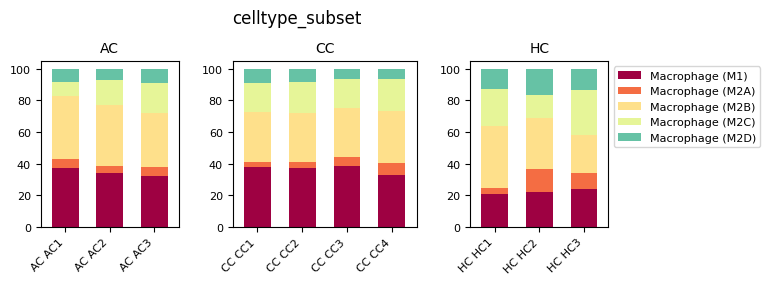

In [ ]:
## 특정 세포유형의 subset별 상대비율을 얻기 위해 특정 세포 유형만 선택
## 이 경우 Macrophage subset의 상대비율을 보기 위해 먼저 minor type이 macrophage인 cell들만 선택
b = adata_t.obs['celltype_minor'] == 'Macrophage'
adata_s = adata_t[b,:]

## 샘플별로 macrophage subset의 개수와 상대비율을 얻어서 데이터프레임에 저장
col = 'celltype_subset'
df_cnt, df_pct = get_population( adata_s.obs['sample_ext'], adata_s.obs[col], sort_by = [] )
display(df_cnt)

plot_population_grouped( df_pct, sample_group_map, sort_by = [],
                         title = col, title_fs = 12, title_y_pos = 1.2,
                         label_fs = 10, bar_width = 0.6,
                         tick_fs = 8, xtick_rot = 45, xtick_ha = 'right',
                         legend_fs = 8, legend_loc = 'upper left',
                         bbox_to_anchor = (1,1), legend_ncol = 1,
                         cmap_name = None, figsize=(7, 2), wspace = 0.35, dpi = 100)

In [ ]:
## 요부분은 sample 별 population을 얻어 조건별로 population이 유의하게
## 차이가 나는지 확인하는 부분입니다.
## 따라서, condition 당 sample이 최소 2개 이상 있는 경우 결과가 나오고
## sample이 많을 수록 통계적 유의성이 커짐 (p-value가 작아짐)

df_res = test_group_diff( df_pct, sample_group_map, ref_group = 'HC', pval_cutoff = 0.8 )
display(df_res)

AC_vs_HC  CC_vs_HC
Macrophage (M1)   0.004877  0.000270
Macrophage (M2D)  0.028291  0.017464
Macrophage (M2A)  0.324639  0.287709
Macrophage (M2C)  0.227983  0.558223
Macrophage (M2B)  0.332813  0.933281

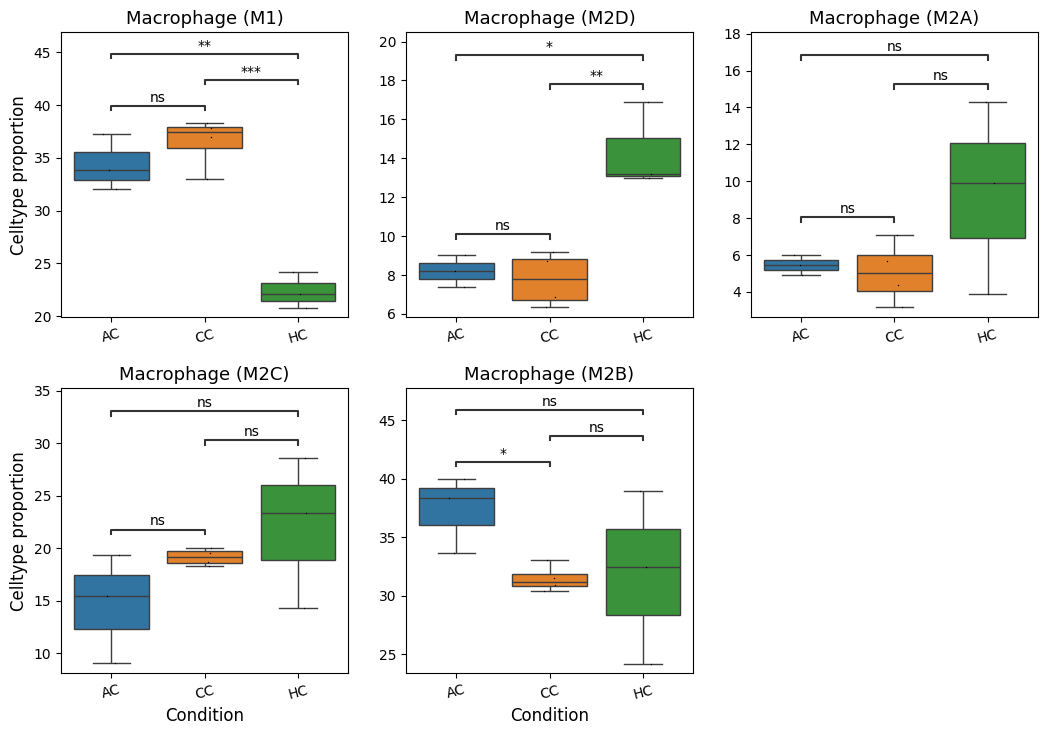

In [ ]:
## 표시할 결과 항목을 선택: 최대 8개만
max_n_items_to_plot = 8
idx_sel = df_res.index.values.tolist()[:min(max_n_items_to_plot, df_res.shape[0])]

if len(idx_sel) > 0:
    ## Show the first 5 CCIs
    plot_pct_box(df_pct[idx_sel], sample_group_map, ylabel = 'Celltype proportion',
                 ncols = 3, figsize = (3.5,3.5), dpi = 100,
                 group_order = None, # ['Normal', 'ER+', 'HER2+', 'TNBC'],
                 title = None, title_y_pos = 1.05, title_fs = 15,
                 label_fs = 12, tick_fs = 10, xtick_rot = 15,
                 annot_ref = None, annot_fmt = 'star', annot_fs = 10,
                 ws_hs = (0.2, 0.25), stripplot = True, cmap = 'tab10')

### __B. CNV & tumor cell identification 결과__
#### <font color=blue>(This works only if you checked "Tumor cell Identification" box when running SCODA)</font>

- __InferCNVpy:__ https://infercnvpy.readthedocs.io/en/latest/infercnv.html
- __InferPloidy:__

### __B.1 Inspecting CNV estimates using heatmap__
- We first group the cells into appropriate groups
- then compare the CNV patterns of the resulting cell groups using a heatmap.

In [ ]:
## adata_t의 사본을 만들어서 adata에 저장
## 이렇게하면 adata에 대해 처리한 내용이 원본에는 반영되지 않음
adata = adata_t[:,:]

## cell들을 Grouping 하기 위해 obs 필드에 'cell_group' 열을 새로 정의
## 기본적으로 major type의 이름을 사용
adata.obs['cell_group'] = adata.obs['celltype_major'].copy(deep = True).astype(str)

## condition 열에 정의된 유방암 subtype에 따라 암세포로 식별된 세포들의
## 이름에 유방암 subtype을 추가하여 이름 변경
## 예: condition이 ER+인 샘플중 Tumor cell들은 이름을 'Tumor ER+'로 변경
cond_col = 'condition'
clst = adata.obs[cond_col].unique()
for c in clst:
    b = (adata.obs[cond_col] == c) & (adata.obs['ploidy_dec'] == 'Aneuploid')
    s = 'Aneuploid Epi in %s' % c
    adata.obs.loc[b, 'cell_group'] = s

## 'cell_group'열 기준으로 Grouping하여 각 그룹별 CNV 패턴을 비교
axd = plot_cnv( adata, groupby = 'cell_group', N_cells_min = 200,
                title = 'log2(CNR)', title_fs = 12, title_y_pos = 1.1,
                label_fs = 12, tick_fs = 11,
                figsize = (15, 8), swap_axes = False,
                var_group_rotation = 90, cmap='RdBu_r', vmax = 1,
                cnv_obsm_key = 'X_cnv', cnv_uns_key = 'cnv', show_ticks = True,
                xlabel = 'Genomic spot', xtick_rot = 0, xtick_ha = 'center')

### __B.2 Comparison of CNV patterns across samples using only cells identified as tumor cells__

In [ ]:
b = adata.obs['tumor_origin_ind']
adata_s = adata[b,:]

cell_grouping = 'sample_ext_for_deg'

## cell_grouping열 기준으로 Grouping하여 각 그룹별 CNV 패턴을 비교
axd = plot_cnv( adata_s, groupby = cell_grouping, N_cells_min = 200,
                title = None, title_fs = 12, title_y_pos = 1.1,
                label_fs = 12, tick_fs = 10,
                figsize = (15, 10), swap_axes = False,
                var_group_rotation = 90, cmap='bwr', vmax = 1,
                cnv_obsm_key = 'X_cnv', cnv_uns_key = 'cnv', show_ticks = True,
                xlabel = 'Genomic spot', xtick_rot = 0, xtick_ha = 'center')

### __B.3 Finding genomic spots where CNV has a peak__

In [ ]:
## Select cells of interest
b = adata.obs['tumor_origin_ind']
adata_s = adata[b,:]

cnv_peaks = find_genomic_spots_of_cnv_peaks( adata_s, group_col = 'condition', width = 5, std_scale = 5, q = None )
cnv_peaks

In [ ]:
cnv_peaks['HER2+']

### __B.4 Visualizing CNV patterns using UMAP projection__

In [ ]:
# adata = adata_t[:,:]

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep = 'X_cnv_pca', key_added = 'cnv_neighbors')
ad_tmp = sc.tl.umap(adata, neighbors_key = 'cnv_neighbors', copy = True)
adata.obsm['X_cnv_umap'] = ad_tmp.obsm['X_umap']
# sc.tl.leiden(adata, resolution = 4, neighbors_key = 'cnv_new', key_added = 'cnv_cluster')

In [ ]:
items_to_plot = ['condition', 'celltype_major', 'cnv_ref_ind', 'ploidy_dec', 'sample']

adata.obs['cnv_ref_ind'] = adata.obs['cnv_ref_ind'].astype(str)
adata.obs['tumor_origin_ind'] = adata.obs['tumor_origin_ind'].astype(str)

plt.rcParams['figure.figsize'] = (3.5, 3.5)
fig = sc.pl.embedding( adata, basis = 'X_cnv_umap', neighbors_key = 'cnv_neighbors',
                       color=items_to_plot, wspace = 0.35, legend_fontsize = 10,
                       ncols = 2, palette = 'Spectral', return_fig = False,
                       add_outline = True)

### __B.5  Inspecting aneuploid/diploid cell population__

In [ ]:
## 샘플별 세포 개수 및  상대비율을 얻어서 데이터프레임에 저장
b = adata_t.obs['tumor_origin_ind']
adata_s = adata_t[b,:]

## 샘플별 세포 개수 확인
sg_map = get_sample_to_group_map(adata_s.obs['sample'], adata_s.obs['condition'])

col = 'ploidy_dec'
df_cnt, df_pct= get_population( adata_s.obs['sample_ext'],
                                adata_s.obs[col], sort_by = [] )

plot_population_grouped( df_pct, sg_map, sort_by = ['Aneuploid'], bar_width = 0.6,
                 title = None, title_fs = 10, title_y_pos = 1.15, dpi = 120,
                 label_fs = 9, tick_fs = 8, xtick_rot = 90, xtick_ha = 'center',
                 legend_fs = 8, legend_loc = 'upper left', bbox_to_anchor = (1,1),
                 legend_ncol = 1, cmap_name = None, figsize=(6, 1), wspace = 0.35)


### __C. Cell-cell interaction analysis results__
- 샘플별 CCI 결과와 조건별 CCI 결과가 따로 저장되어 있음
- 데이터 포맷은 두 결과가 동일함
- 조건별 CCI는 해당 조건에 포함된 샘플중 일정 퍼센트 이상의 샘플에서 공통적으로 확인된 것들만 추린 것임.
- __CellPhoneDB:__ https://www.cellphonedb.org/

#### __C.1 Structure and format of the cell–cell interaction results__

<div>
<img src="https://drive.google.com/uc?export=view&id=1091cGa6DqKSybzWSd6YE7amC2HDqNIn6" align="center" width="320"/>
</div>

<div>
<img src=attachment:48abf5fd-8f00-4f14-9a91-bb5b872d7275.png width="320"/>   
</div>

In [ ]:
## 샘플 별 CCI 결과
cci_df_dct = adata_t.uns['CCI_sample']
sample_lst = list(cci_df_dct.keys())
sample_lst

In [ ]:
## CCI results in a data frame
cci_df_dct[sample_lst[-1]]

In [ ]:
## Condition 별 CCI 결과
cci_df_dct_per_cond = adata_t.uns['CCI']
cond_lst = list(cci_df_dct_per_cond.keys())
cond_lst

['AC', 'CC', 'HC']

#### __C.2 Inspecting condition-specific CCIs__

In [ ]:
cci_df_dct_per_cond = adata_t.uns['CCI']

In [ ]:
adata_t.obs['celltype_for_cci'].value_counts()

celltype_for_cci
B cell                11828
Fibroblast             8575
T cell CD4+            5313
Endothelial cell       4172
Macrophage             2428
Epithelial cell        2075
ILC                    1569
Smooth muscle cell     1247
Plasma cell             755
Dendritic cell          541
unassigned              128
T cell CD8+             102
Basal cell               68
Mesothelial cell         62
NK cell                  37
Name: count, dtype: int64

9 cell_pairs, 81 gene_pairs found


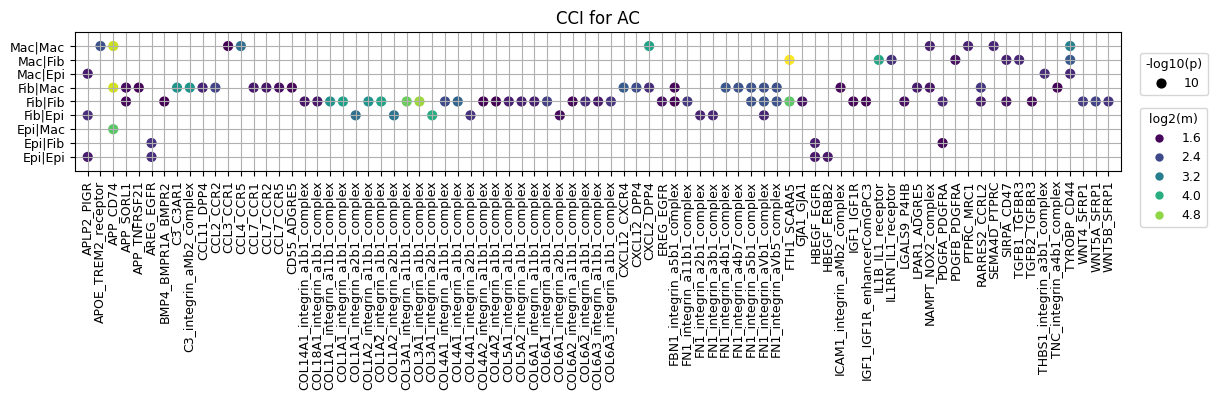

9 cell_pairs, 81 gene_pairs found


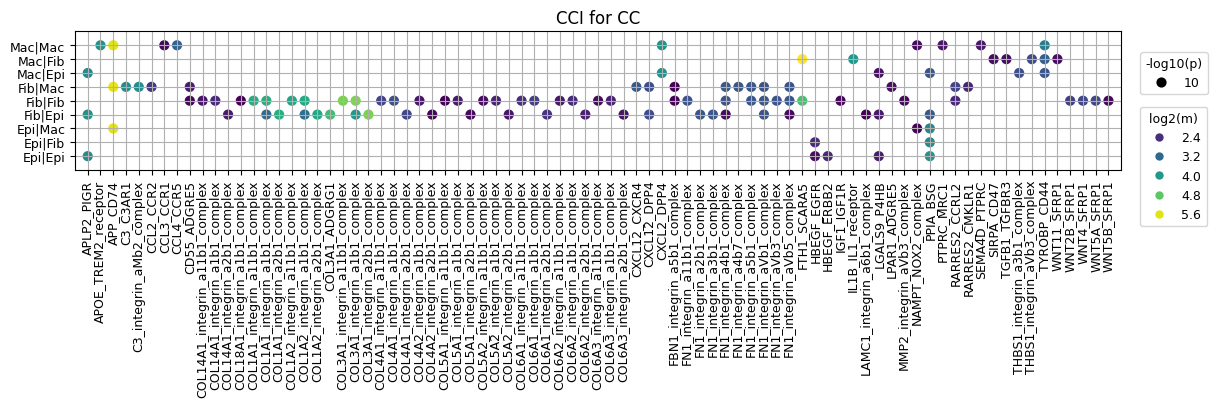

9 cell_pairs, 81 gene_pairs found


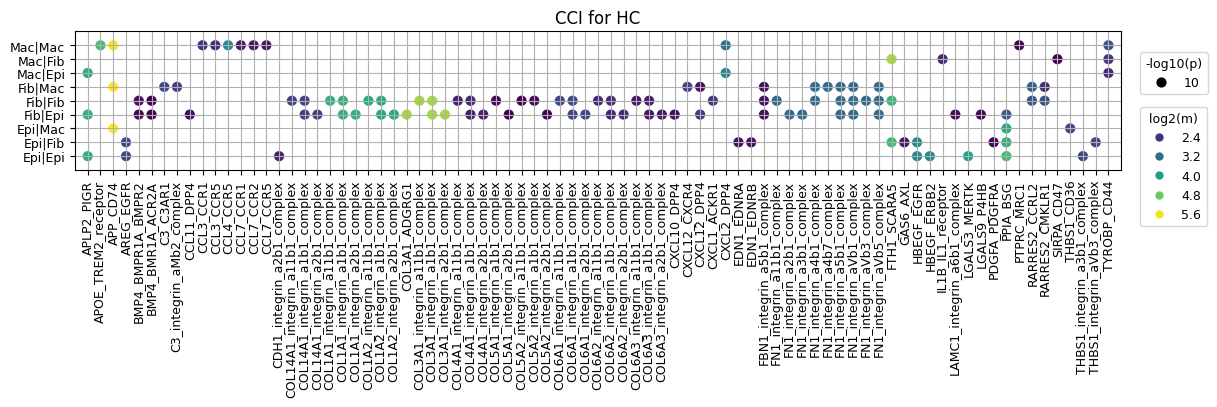

In [ ]:
## 특정 target cell이 포함된 interaction들만 확인함. (모든 CCI를 다 보려면 target_cells을 []로 설정)
target_cells = ['Epithelial cell', 'Macrophage', 'Fibroblast']
target_genes = []

ax = plot_cci_dot( cci_df_dct_per_cond, n_gene_pairs = 80,
                   target_cells = target_cells, target_genes = target_genes,
                   pval_cutoff = 0.1, mean_cutoff = 0.1,
                   rename_cells = rename_dict['celltype_minor'],
                   title = None, title_fs = 12,
                   legend_fs = 9, legend_mkr_sz = 9,
                   tick_fs = 9, xtick_rot = 90, xtick_ha = 'center',
                   dpi = 100, swap_ax = True, cmap = None ) # 'Reds')

### __C.3 Exploring CCis associated with a specific gene set__  

In [ ]:
b1 = adata_t.var_names.str.startswith('Ccl')
b2 = adata_t.var_names.str.startswith('Cxcl')
b3 = adata_t.var_names.str.startswith('Il')

genes_sel = list(adata_t.var.index.values[b1 | b2 | b3])
np.array(genes_sel)

array(['Il17a', 'Il17f', 'Il1r2', 'Il1r1', 'Il1rl2', 'Il1rl1', 'Il18r1',
       'Il18rap', 'Ccl20', 'Ilkap', 'Il24', 'Il19', 'Il10', 'Ildr2',
       'Il2ra', 'Il15ra', 'Il1f9', 'Il1f6', 'Il1rn', 'Il1a', 'Il1b',
       'Il1bos', 'Il7', 'Il2', 'Il21', 'Il12a', 'Il6ra', 'Ilf2',
       'Il11ra1', 'Ccl27a', 'Ccl19', 'Ccl21a', 'Il22ra1', 'Il6', 'Cxcl5',
       'Cxcl3', 'Cxcl1', 'Cxcl2', 'Cxcl9', 'Cxcl10', 'Cxcl13', 'Il31',
       'Ccl24', 'Il12rb2', 'Il23r', 'Il5ra', 'Il17re', 'Il17rc', 'Cxcl12',
       'Il17ra', 'Il11', 'Cxcl17', 'Il4i1', 'Il16', 'Il18bp', 'Ilk',
       'Il4ra', 'Il21r', 'Il27', 'Ccl25', 'Il12rb1', 'Il15', 'Il27ra',
       'Ccl22', 'Ccl17', 'Il34', 'Il17c', 'Ilf3', 'Il10ra', 'Il18',
       'Il20rb', 'Il22ra2', 'Il20ra', 'Ilvbl', 'Il22', 'Iltifb', 'Il23a',
       'Il9r', 'Il12b', 'Il4', 'Il13', 'Il5', 'Cxcl16', 'Ccl2', 'Ccl7',
       'Ccl11', 'Ccl12', 'Ccl8', 'Ccl1', 'Ccl5', 'Ccl9', 'Ccl6', 'Ccl3',
       'Ccl4', 'Cxcl14', 'Il6st', 'Il31ra', 'Ccl28', 'Il3ra', 'Il17rd',
     

7 cell_pairs, 25 gene_pairs found


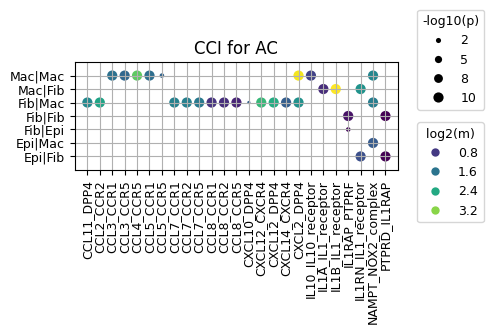

8 cell_pairs, 25 gene_pairs found


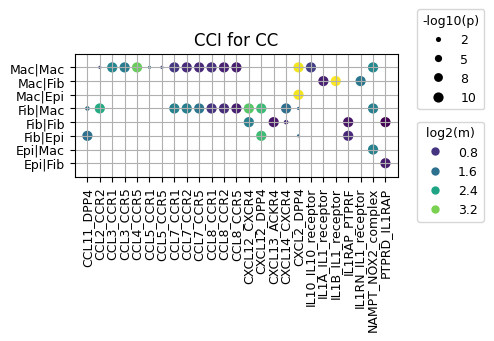

8 cell_pairs, 24 gene_pairs found


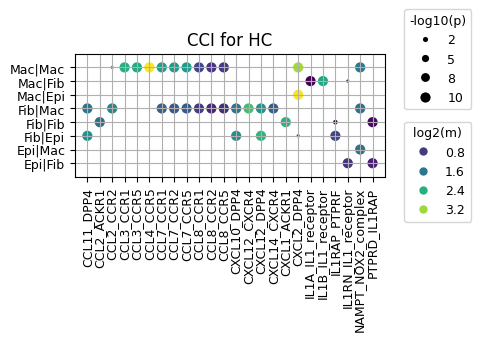

In [ ]:
## 특정 target cell이 포함된 interaction들만 확인함. (모든 CCI를 다 보려면 target_cells을 []로 설정)
target_cells = ['Epithelial cell', 'Macrophage', 'Fibroblast']

## CellPhoneDB는 인간 유전자 이름만 사용하므로 마우스의 경우 유전자 이름을 대문자로 변경 필요.
target_genes = [g.upper() for g in genes_sel] + ['NAMPT']

ax = plot_cci_dot( cci_df_dct_per_cond, n_gene_pairs = 60,
                   target_cells = target_cells, target_genes = target_genes,
                   pval_cutoff = 0.1, mean_cutoff = 0.1,
                   rename_cells = rename_dict['celltype_minor'],
                   title = None, title_fs = 12,
                   legend_fs = 9, legend_mkr_sz = 9,
                   tick_fs = 9, xtick_rot = 90, xtick_ha = 'center',
                   dpi = 100, swap_ax = True, cmap = None ) # 'Reds')

### __C.4 Inspecting per-sample CCIs__

In [ ]:
cci_df_dct = adata_t.uns['CCI_sample']

## 특정 target cell이 포함된 interaction들만 확인함. (모든 CCI를 다 보려면 target_cells을 []로 설정)
target_cells = ['Epithelial cell', 'Macrophage', 'Fibroblast']
target_genes = []

ax = plot_cci_dot( cci_df_dct, n_gene_pairs = 80,
                   target_cells = target_cells, target_genes = target_genes,
                   pval_cutoff = 0.1, mean_cutoff = 0.1,
                   rename_cells = rename_dict['celltype_minor'],
                   title = None, title_fs = 12,
                   legend_fs = 9, legend_mkr_sz = 9,
                   tick_fs = 9, xtick_rot = 90, xtick_ha = 'center',
                   dpi = 100, swap_ax = True, cmap = None ) # 'Reds')

#### __C.5 Statistical test for condition-specific differences in CCI strength__
샘플별 CCI 결과에서 모든 샘플에서 공통적으로 확인된 CCI를 골라서 \
각 조건별로 상호작용의 강도간 유의한 차이가 있는지 확인할 수 있음

In [ ]:
target_cells = ['Epithelial cell', 'Macrophage', 'Fibroblast']
target_genes = []

cci_df_dct = adata_t.uns['CCI_sample']

## mean 값을 가져오된 pval가 cutoff 보다 작은 것들만 가져옴
df = get_cci_means( cci_df_dct, cci_idx_lst = None,
                    cells = target_cells, genes = target_genes, pval_cutoff = 0.1 )
## cci_idx_lst를 None으로 설정하면 cci_df_dct에 있는 모든 CCI들의 union에 대한 결과를 리턴함 (pval_cutoff은 적용됨)
## 리턴 결과가 0인 것은 해당 샘플에서 해당 CCI가 검출되지 않은 것임.

df_res = test_group_diff( df, sample_group_map, ref_group = None, pval_cutoff = 0.05 )
df_res

CC_vs_AC  HC_vs_AC  \
COL18A1_integrin_a11b1_complex--Fibroblast|Fibr...  0.013850  0.000190   
NECTIN2_NECTIN3--Endothelial cell|Epithelial cell   0.022405  0.000706   
SELPLG_SELP--Macrophage|Endothelial cell            0.003116  0.002212   
THY1_ADGRE5--T cell CD4+|Macrophage                 0.010924  0.015962   
CD34_SELP--Fibroblast|Endothelial cell              0.003103  0.022262   
...                                                      ...       ...   
THBS1_integrin_aVb3_complex--Epithelial cell|Fi...  1.000000  1.000000   
TNFSF13_TNFRSF17--Epithelial cell|Plasma cell       1.000000  1.000000   
APLP2_PIGR--Plasma cell|Epithelial cell             1.000000  1.000000   
APP_TNFRSF21--Epithelial cell|Smooth muscle cell    1.000000  1.000000   
JAG2_VASN--Endothelial cell|Epithelial cell         1.000000  1.000000   

                                                    HC_vs_CC  
COL18A1_integrin_a11b1_complex--Fibroblast|Fibr...  0.000326  
NECTIN2_NECTIN3--Endothelial cell|Epithelial cell   0.000098  
SELPLG_SELP--Macrophage|Endothelial cell            0.001254  
THY1_ADGRE5--T cell CD4+|Macrophage                 0.000567  
CD34_SELP--Fibroblast|Endothelial cell              0.002372  
...                                                      ...  
THBS1_integrin_aVb3_complex--Epithelial cell|Fi...  0.045559  
TNFSF13_TNFRSF17--Epithelial cell|Plasma cell       0.046290  
APLP2_PIGR--Plasma cell|Epithelial cell             0.047488  
APP_TNFRSF21--Epithelial cell|Smooth muscle cell    0.048590  
JAG2_VASN--Endothelial cell|Epithelial cell         0.049700  

[506 rows x 3 columns]

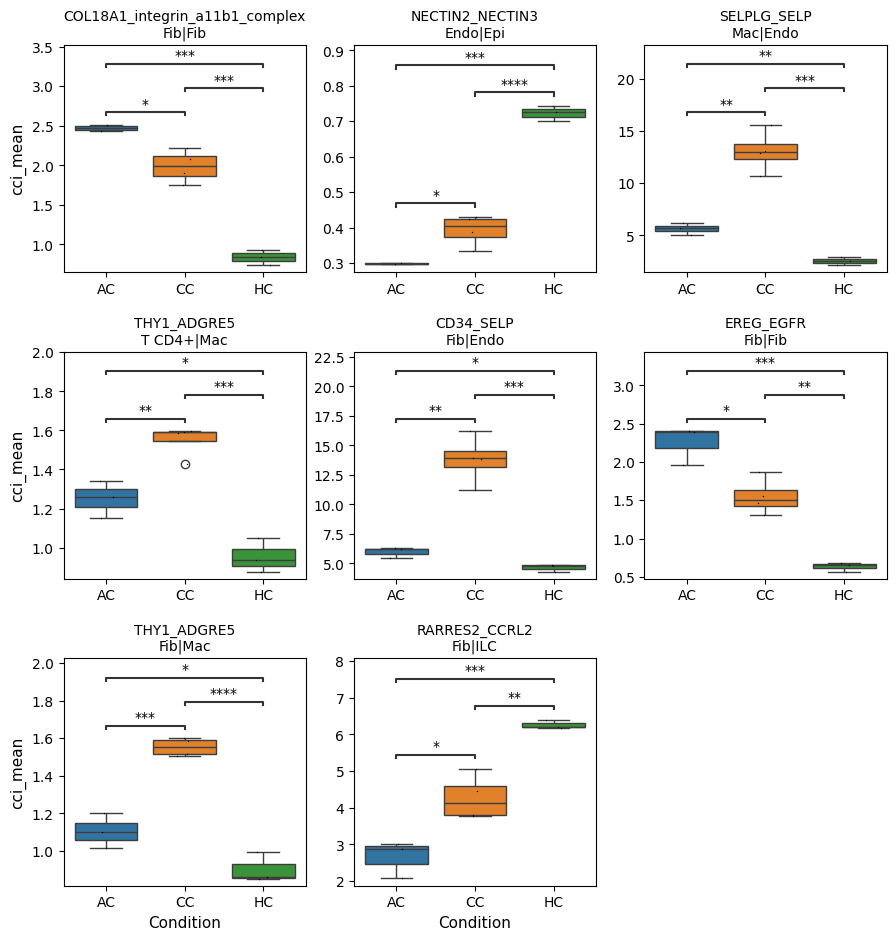

In [ ]:
## 요부분은 sample 별 CCI의 mean이(CCI의 강도가) 조건별로 유의하게
## 차이가 나는지 확인하는 부분입니다.
## 따라서, condition 당 sample이 최소 2개 이상 있는 경우 결과가 나오고
## sample이 많을 수록 통계적 유의성이 커지고요. (p-value가 작아지고요)

## 표시할 결과 항목을 선택: 최대 8개만
max_n_items_to_plot = 8
idx_sel = df_res.index.values.tolist()[:min(max_n_items_to_plot, df_res.shape[0])]

if len(idx_sel) > 0:
    df_sel = df[idx_sel].copy(deep = True)

    plot_pct_box(df_sel, sample_group_map, ylabel = 'cci_mean',
              ncols = 3, figsize = (3,3), dpi = 100, rename_cells = rename_dict['celltype_minor'],
              title = None, title_y_pos = 1.05, title_fs = 12,
              label_fs = 11, tick_fs = 10, xtick_rot = 0, xtick_ha = 'center',
              annot_ref = None, annot_fmt = 'star', annot_fs = 10,
              ws_hs = (0.2, 0.35), stripplot = True)

#### __C.6 Statistical test for condition-specific differences in CCI strength (specifying genes to consider)__
샘플별 CCI 결과에서 여러 샘플에서 공통적으로 확인된 CCI를 골라서 \
각 조건별로 상호작용의 강도간 유의한 차이가 있는지 확인할 수 있음

In [ ]:
target_cells = ['Epithelial cell', 'Macrophage', 'Fibroblast']
target_genes = ['IL1B', 'NAMPT']

cci_df_dct = adata_t.uns['CCI_sample']

## mean 값을 가져오된 pval가 cutoff 보다 작은 것들만 가져옴
df = get_cci_means( cci_df_dct, cci_idx_lst = None,
                    cells = target_cells, genes = target_genes, pval_cutoff = 0.1 )
## cci_idx_lst를 None으로 설정하면 cci_df_dct에 있는 모든 CCI들의 union에 대한 결과를 리턴함 (pval_cutoff은 적용됨)
## 리턴 결과가 0인 것은 해당 샘플에서 해당 CCI가 검출되지 않은 것임.

df_res = test_group_diff( df, sample_group_map, ref_group = None, pval_cutoff = 0.05 )
df_res

CC_vs_AC  HC_vs_AC  HC_vs_CC
IL1B_IL1_receptor--Macrophage|Fibroblast         0.798515  0.006343  0.042821
NAMPT_NOX2_complex--Endothelial cell|Macrophage  0.413311  0.038773  0.023707
NAMPT_NOX2_complex--Macrophage|Macrophage        0.465400  0.117371  0.033936
NAMPT_NOX2_complex--Epithelial cell|Macrophage   0.105169  0.571637  0.036815

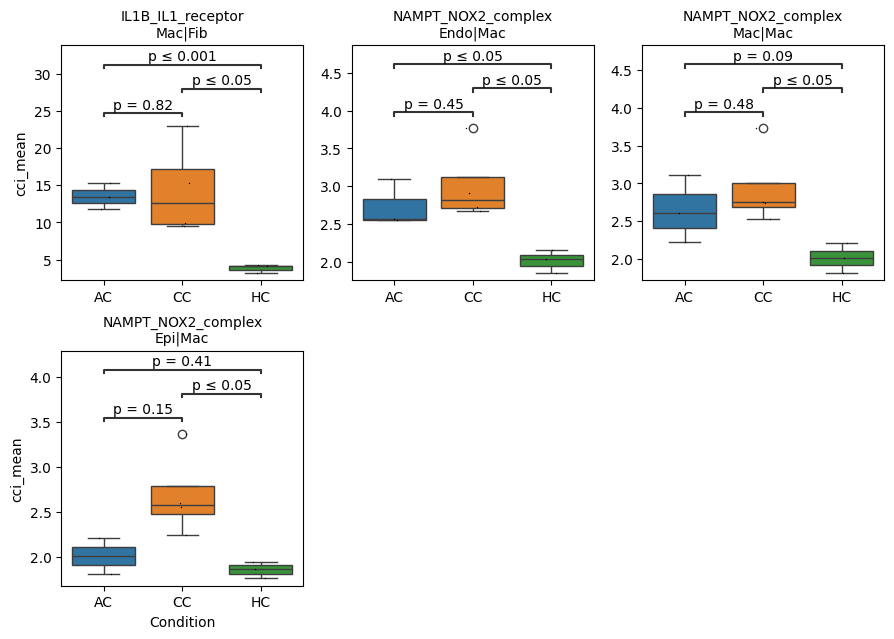

In [ ]:
## 요부분은 sample 별 CCI의 mean이(CCI의 강도가) 조건별로 유의하게
## 차이가 나는지 확인하는 부분입니다.
## 따라서, condition 당 sample이 최소 2개 이상 있는 경우 결과가 나오고
## sample이 많을 수록 통계적 유의성이 커지고요. (p-value가 작아지고요)

## 표시할 결과 항목을 선택: 앞에서 8개만
max_n_items_to_plot = 8
idx_sel = df_res.index.values.tolist()[:min(max_n_items_to_plot, df_res.shape[0])]

if len(idx_sel) > 0:
    df_sel = df[idx_sel].copy(deep = True)

    ## Show the selected CCIs
    plot_pct_box(df_sel, sample_group_map, ylabel = 'cci_mean',
              ncols = 3, figsize = (3,3), dpi = 100, rename_cells = rename_dict['celltype_minor'],
              title = None, title_y_pos = 1.05, title_fs = 12,
              label_fs = 10, tick_fs = 10, xtick_rot = 0, xtick_ha = 'center',
              annot_ref = None, annot_fmt = 'simple', annot_fs = 10,
              ws_hs = (0.2, 0.3), stripplot = True)

#### __C.7 Circle plots for an overview of cell-cell interactions__

In [ ]:
## DataFrame들의 dictionalry로 되어 있는 CCI 결과를 가져옴
cci_df_dct = adata_t.uns['CCI_sample']

plot_cci_circ_group( cci_df_dct, target = None,
                     rename_cells = rename_dict['celltype_minor'],
                     remove_common = False, ncol = 4, figsize = (3.5,3.5),
                     title = None, title_y_pos = 1.1, title_fs = 24,
                     text_fs = 9, num_fs = 7, margin = 0.08,
                     dpi = 100, alpha = 0.5, R_curvature = 3,
                     linewidth_max = 8, linewidth_log = False,
                     node_size = 8, rot = False, cmap = 'Spectral',
                     wspace = 0.15, hspace = 0.1 )

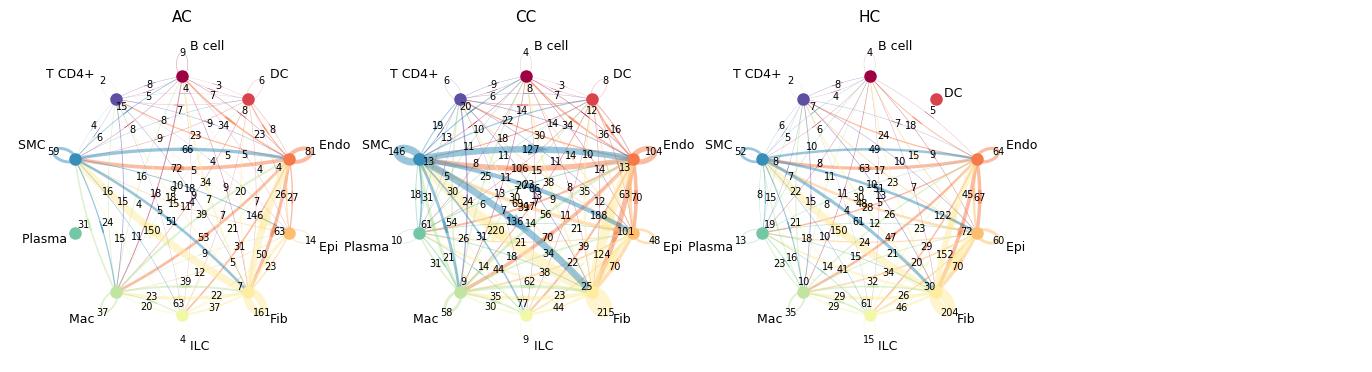

In [ ]:
## DataFrame들의 dictionalry로 되어 있는 CCI 결과를 가져옴
cci_df_dct_per_cond = adata_t.uns['CCI']

plot_cci_circ_group( cci_df_dct_per_cond, target = None,
                     rename_cells = rename_dict['celltype_minor'],
                     remove_common = False, ncol = 4, figsize = (3.5,3.5),
                     title = None, title_y_pos = 1.1, title_fs = 24,
                     text_fs = 9, num_fs = 7, margin = 0.08,
                     dpi = 100, alpha = 0.5, R_curvature = 3,
                     linewidth_max = 8, linewidth_log = False,
                     node_size = 8, rot = False, cmap = 'Spectral',
                     wspace = 0.15, hspace = 0.1 )

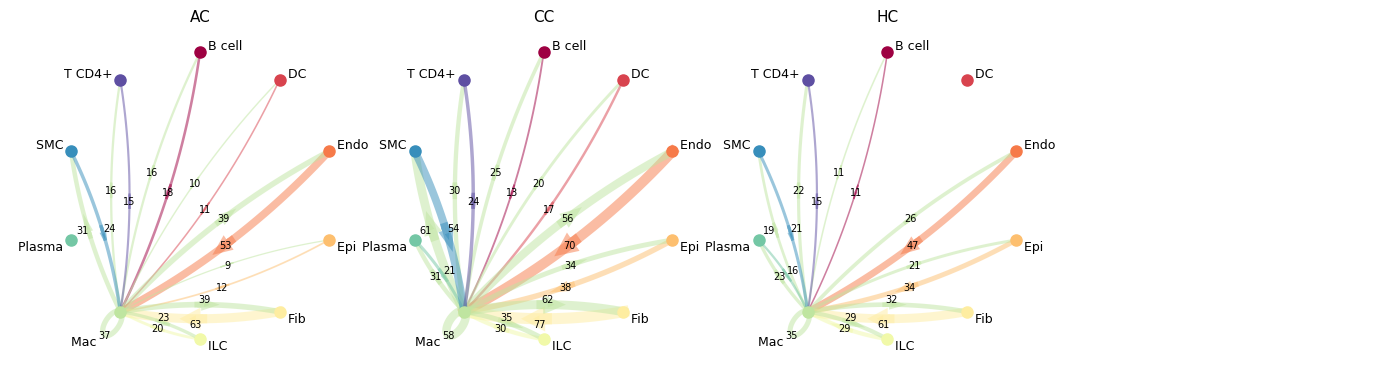

In [ ]:
## DataFrame들의 dictionalry로 되어 있는 CCI 결과를 가져옴
cci_df_dct_per_cond = adata_t.uns['CCI']

## 특정 세포유형을 중심으로 CCI 개수 확인 (이 경우 Epithelial cell을 중심으로 봄)
target = ['Mac']

plot_cci_circ_group( cci_df_dct_per_cond, target = target,
                     rename_cells = rename_dict['celltype_minor'],
                     remove_common = False, ncol = 4, figsize = (3.5,3.5),
                     title = None, title_y_pos = 1.1, title_fs = 24,
                     text_fs = 9, num_fs = 7, margin = 0.08,
                     dpi = 100, alpha = 0.5, R_curvature = 3,
                     linewidth_max = 8, linewidth_log = False,
                     node_size = 8, rot = False, cmap = 'Spectral',
                     wspace = 0.15, hspace = 0.1 )

### __D. DEG analysis results and marker/target discovery__
- DEG 결과는 각 세포 유형별로 처리되어 저장됨
- major, minor, subset 중 어느 수준을 기준으로 할지는 analysis_parameters에서 정의 할 수 있음
- 현재의 결과는 celltype_minor 기준으로 세포 유형별로 condition-specific DEG를 얻은 결과 임.

In [ ]:
adata_t

AnnData object with n_obs × n_vars = 38900 × 20582
    obs: 'sample', 'condition', 'sample_ext', 'celltype_major', 'celltype_minor', 'celltype_subset'
    var: 'gene_ids', 'feature_types', 'variable_genes'
    uns: 'CCI', 'CCI_sample', 'Celltype_marker_DB', 'DEG', 'DEG_grouping_vars', 'DEG_stat', 'DEG_vs_ref', 'DEG_vs_ref_stat', 'GSA_down', 'GSA_up', 'GSA_vs_ref_down', 'GSA_vs_ref_up', 'GSEA', 'GSEA_vs_ref', 'HiCAT_summary', 'Pathways_DB', 'analysis_parameters', 'log', 'lut_sample_to_cond', 'usr_param'
    obsm: 'HiCAT_result', 'X_pca'

In [ ]:
nc_deg_dct_of_dct = adata_t.uns['DEG_stat'] ## DEG 분석에 사용된 셀수 정보
df_deg_dct_of_dct = adata_t.uns['DEG'] ## DEG 분석 결과

## 어떤 세포 유형들에 대한 DEG 결과가 있는지 확인
list(df_deg_dct_of_dct.keys())

## analysis_parameters에 정의한 DEG분석을 위한 최소 셀수(MIN_NUM_CELLS_FOR_DEG)보다
## 적은 셀수를 갖는 세포 유형에 대해서는 DEG 분석이 수행 되지 않음.
## (각 조건 별로 해당 유형의 셀수가 최소한 MIN_NUM_CELLS_FOR_DEG 정도되어야 DEG 분석이 수행됨)

['B cell',
 'Dendritic cell',
 'Endothelial cell',
 'Epithelial cell',
 'Fibroblast',
 'ILC',
 'Macrophage',
 'Plasma cell',
 'Smooth muscle cell',
 'T cell CD4+']

#### __D.1 Structure and format of the DEG results__

##### __DEG 결과 데이터의 구성__

<div>
<img src="https://drive.google.com/uc?export=view&id=1N-XeRpAvUAlnuryLpll7sYyzGbKGK5eG" align="center" width="500"/>
</div>

<div>
<img src=attachment:f57fafbd-8253-4210-88ed-9acbc3224d08.png width="500"/>   
</div>

In [ ]:
## 특정 세포 유형에 대한 DEG 분석 결과를 가져옴 (이경우 Epithelial cell)
target_cell = 'Macrophage'

df_deg_dct = df_deg_dct_of_dct[target_cell]
nc_deg_dct = nc_deg_dct_of_dct[target_cell]

## 해당 세포 유형에 사용된 조건 별 셀수 확인
nc_deg_dct

{'AC_vs_others': {'AC': 540, 'others': 923},
 'CC_vs_others': {'CC': 678, 'others': 785},
 'HC_vs_others': {'HC': 245, 'others': 1218}}

In [ ]:
df_deg_dct['CC_vs_others'].head()

log2_FC          pval      pval_adj  mean_test  mean_ref  nz_pct_test  \
Ighg2b    3.539  2.325895e-41  1.790707e-37   1.067398  0.151983     0.457227   
Ighm      1.472  4.654128e-11  3.628358e-07   1.216879  0.618815     0.517699   
Cmpk1     0.573  2.033738e-04  1.000000e+00   0.870513  0.659178     0.532448   
Bri3      0.540  6.336883e-03  1.000000e+00   1.573160  1.288679     0.663717   
Mrfap1    0.556  3.696601e-03  1.000000e+00   0.873972  0.667901     0.536873   

        nz_pct_ref  nz_pct_score    gene   Rp  
Ighg2b    0.090741      0.415738  Ighg2b  1.0  
Ighm      0.342857      0.340202    Ighm  1.0  
Cmpk1     0.388889      0.325385   Cmpk1  1.0  
Bri3      0.510204      0.325086    Bri3  1.0  
Mrfap1    0.396296      0.324112  Mrfap1  1.0

- nz_pct_score = nz_pct_test*(1-nz_pct_ref)
- nz_pct_test: percentage of cells with the gene expressed in test group
- nz_pct_ref: percentage of cells with the gene expressed in reference group

#### __D.2 Gene ranking per celltype__

Macrophage


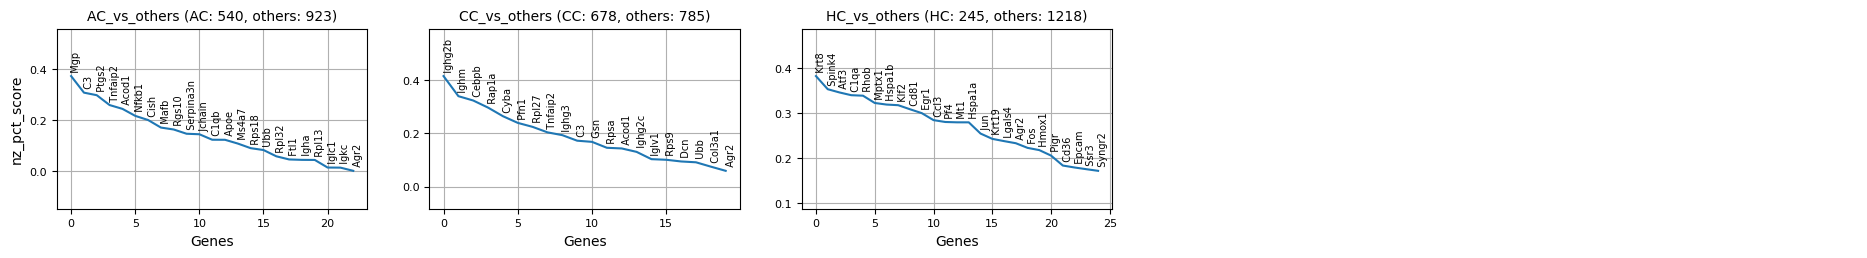

In [ ]:
key = 'Macrophage'
df_deg_dct = df_deg_dct_of_dct[key]
nc_deg_dct = nc_deg_dct_of_dct[key]

n_genes_to_show = 25

print(key)
plot_deg( df_deg_dct, reference = 'nz_pct_score',
          n_genes_to_show = n_genes_to_show, pval_cutoff = 0.01,
          figsize = (4,2), dpi = 100, text_fs = 7, title_fs = 10, label_fs = 10,
          tick_fs = 8, ncols = 5, wspace = 0.2, hspace = 0.5,
          deg_stat_dct = nc_deg_dct, show_log_pv = False )


In [ ]:
n_genes_to_show = 25

for key in df_deg_dct_of_dct.keys():
    df_deg_dct = df_deg_dct_of_dct[key]
    nc_deg_dct = nc_deg_dct_of_dct[key]

    print(key)
    plot_deg( df_deg_dct, reference = 'nz_pct_score',
              n_genes_to_show = n_genes_to_show, pval_cutoff = 0.01,
              figsize = (4,2), dpi = 100, text_fs = 7, title_fs = 10, label_fs = 10,
              tick_fs = 8, ncols = 5, wspace = 0.2, hspace = 0.5,
              deg_stat_dct = nc_deg_dct, show_log_pv = False )


#### __D.3 Discovery of condition-specific markers (per-celltype)__

In [ ]:
adata_t

AnnData object with n_obs × n_vars = 38900 × 20582
    obs: 'sample', 'condition', 'sample_ext', 'celltype_major', 'celltype_minor', 'celltype_subset', 'celltype_for_cci'
    var: 'gene_ids', 'feature_types', 'variable_genes'
    uns: 'CCI', 'CCI_sample', 'Celltype_marker_DB', 'DEG', 'DEG_grouping_vars', 'DEG_stat', 'DEG_vs_ref', 'DEG_vs_ref_stat', 'GSA_down', 'GSA_up', 'GSA_vs_ref_down', 'GSA_vs_ref_up', 'GSEA', 'GSEA_vs_ref', 'HiCAT_summary', 'Pathways_DB', 'analysis_parameters', 'log', 'lut_sample_to_cond', 'usr_param'
    obsm: 'HiCAT_result', 'X_pca'

In [ ]:
nc_deg_dct_of_dct = adata_t.uns['DEG_stat']
df_deg_dct_of_dct = adata_t.uns['DEG']
df_deg_dct_of_dct.keys()

dict_keys(['B cell', 'Dendritic cell', 'Endothelial cell', 'Epithelial cell', 'Fibroblast', 'ILC', 'Macrophage', 'Plasma cell', 'Smooth muscle cell', 'T cell CD4+'])

In [ ]:
# target_cell = 'Fibroblast'
# target_cell = 'Macrophage'
# target_cell = 'Ductal cell'
target_cell = 'Macrophage'

df_deg_lst = df_deg_dct_of_dct[target_cell]

mkr_dict, df_deg_dct_updated = find_condition_specific_markers( df_deg_lst,
                                            score_col = 'nz_pct_score',
                                            n_markers_max = 40,
                                            score_cutoff = 0.25,
                                            pval_cutoff = 0.05,
                                            nz_pct_fc_cutoff = 1.25,
                                            surfaceome_only = True,
                                            verbose = True )

## Print results
for key in mkr_dict.keys():
    mkr_dict[key].sort()
    print('%s (%i): ' % (key, len(mkr_dict[key])), mkr_dict[key])


N_markers: 
   AC_vs_others (7389 -> 3) 
   CC_vs_others (7541 -> 139) 
   HC_vs_others (7486 -> 26)
N_markers_selected: AC (3), CC (40), HC (26)
AC (3):  ['C3', 'Mgp', 'Ptgs2']
CC (40):  ['1810058I24Rik', 'Anp32b', 'Aprt', 'Atp5a1', 'Atp6v0d1', 'Atp6v0e', 'Atp6v1f', 'Atrx', 'Bri3', 'Card19', 'Cct8', 'Cebpb', 'Cmpk1', 'Cox7a2l', 'Ctsa', 'Cyfip1', 'Gm10076', 'Got1', 'Ighg2b', 'Ighm', 'Lrrc25', 'Mkrn1', 'Mpc1', 'Mrfap1', 'Mtdh', 'Mycbp2', 'Ncf4', 'Ncor1', 'Ninj1', 'Psmb8', 'Rab10', 'Rbx1', 'Rnf130', 'Rsrc2', 'Snx20', 'Supt4a', 'Tmem50a', 'Ubxn1', 'Vapa', 'Zfp91']
HC (26):  ['Atf3', 'Blvrb', 'C1qa', 'C1qb', 'C1qc', 'Ccl2', 'Ccl3', 'Ccnd2', 'Cd63', 'Cd81', 'Gadd45g', 'Glul', 'Hpgds', 'Hspa1b', 'Irs2', 'Klf2', 'Krt8', 'Mptx1', 'Mrc1', 'Ms4a7', 'Pf4', 'Rasgef1b', 'Rhob', 'Spink4', 'Tnf', 'Txnip']


Num markers selected: 59 -> 59


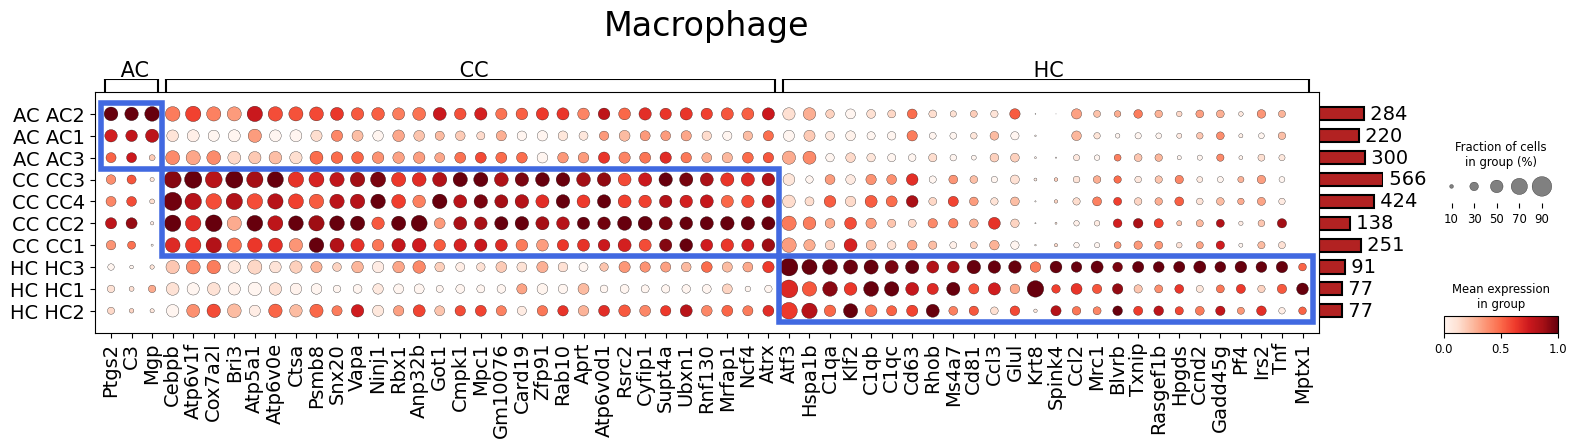

In [ ]:
target_cell = 'Macrophage'
title = target_cell

plot_marker_exp(adata_t, markers = mkr_dict, celltype_selection = target_cell,
                N_cells_per_group_min = 40, N_markers_per_group_max = 30, N_markers_total = 140,
                title = title, title_y_pos = 2, title_fs = 24, text_fs = 14,
                linewidth = 4, var_group_height = 1.2, var_group_rotation = 0,
                standard_scale = 'var', nz_frac_max = 0.9, nz_frac_cutoff = 0.05,
                rem_mkrs_common_in_N_groups_or_more = 3, legend = True,
                figsize = None, swap_ax = False, add_rect = True )

#### __D.4 Examining expression patterns of selected markers using violin plots__

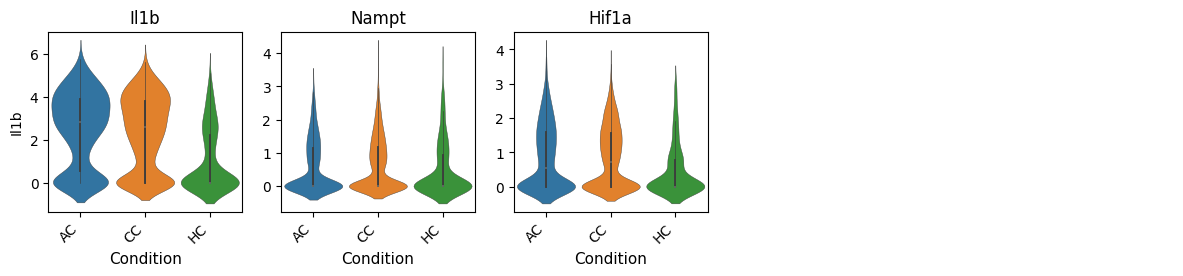

In [ ]:
items_to_plot = ['Il1b', 'Nampt', 'Hif1a']

b = adata_t.obs['celltype_minor'] == 'Macrophage'
adata_s = adata_t[b,:]

## RNA Expression의 log변환 값을 기준으로 violin plot을 확인
sc.pp.normalize_total(adata_s, target_sum=1e4)
sc.pp.log1p(adata_s)

df = adata_s[:, items_to_plot].to_df()
df['group'] = adata_s.obs['condition']

plot_violin( df, genes_lst = items_to_plot, group_col = 'group', scale = 'width',
             group_order = None, inner = 'box', width = 0.9, linewidth = 0.3, bw = 'scott',
             figsize = (2.5,2), dpi = 100,
             text_fs = 10, title = None, title_fs = 14, title_y_pos = 1,
             label_fs = 11, tick_fs = 10, xtick_rot = 45, xtick_ha = 'right',
             ncols = 5, wspace = 0.2, hspace = 0.3, cmap = 'tab10' )

#### __D.5 Statistical test for mean-expression of condition-specific markers__
- 요부분은 sample 별 Gene expression의 평균이 조건별로 유의하게 차이가 나는지 확인하는 부분입니다. (위 코드셀의 결과가 사용됩니다)
- 따라서, condition 당 sample이 최소 2개 이상 있는 경우 결과가 나오고 sample이 많을 수록 통계적 유의성이 커짐. (p-value가 작아짐)

In [ ]:
target_genes = []

df_all = get_gene_expression_mean( adata_s, genes = target_genes, group_col = 'sample_ext' )
df_res = test_group_diff( df_all, sample_group_map,
                          ref_group = None, pval_cutoff = 0.05 )

display(df_res)

CC_vs_AC  HC_vs_AC  HC_vs_CC
Tmem132c  0.006663  0.001218  0.000089
Homez     0.013112  0.001878  0.000054
Hoxa11os  0.001582  0.009685  0.000089
Samhd1    0.028514  0.005203  0.000030
Klkb1     0.001039  0.001502  0.024496
...            ...       ...       ...
Golim4    0.042216  0.591129  0.905395
Gm15859   0.048397  0.769361  0.609672
Tsacc     0.047572  0.608359  0.877406
Decr1     0.047830  0.882712  0.615908
Gm48960   0.041406  0.708069  0.978311

[3420 rows x 3 columns]

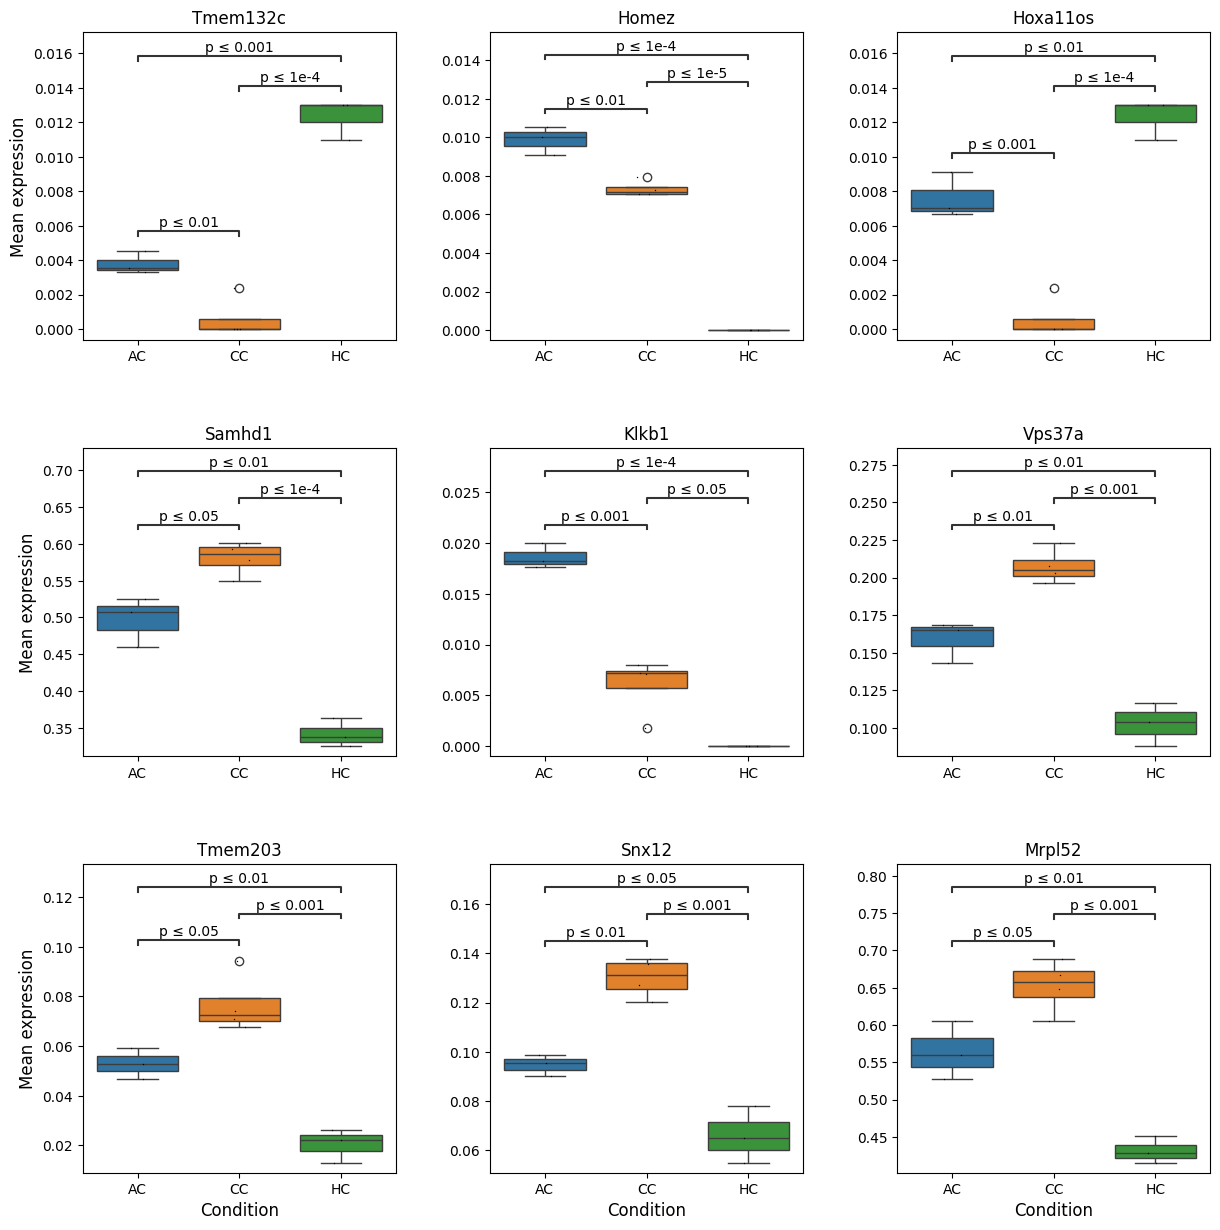

In [ ]:
## Show the first 9 genes
num_items_to_plot = 9
items_to_plot = df_res.iloc[:num_items_to_plot].index.values.tolist()

plot_pct_box( df_all[items_to_plot],
              sample_group_map, ylabel = 'Mean expression',
              ncols = 3, figsize = (4,4), dpi = 100,
              title = None, title_y_pos = 1.05, title_fs = 14,
              label_fs = 12, tick_fs = 10, xtick_rot = 0, xtick_ha = 'center',
              annot_ref = None, annot_fmt = 'simple', annot_fs = 10,
              ws_hs = (0.3, 0.35), stripplot = True)

#### __D.6 Statistical test for mean-expression of some selected genes__


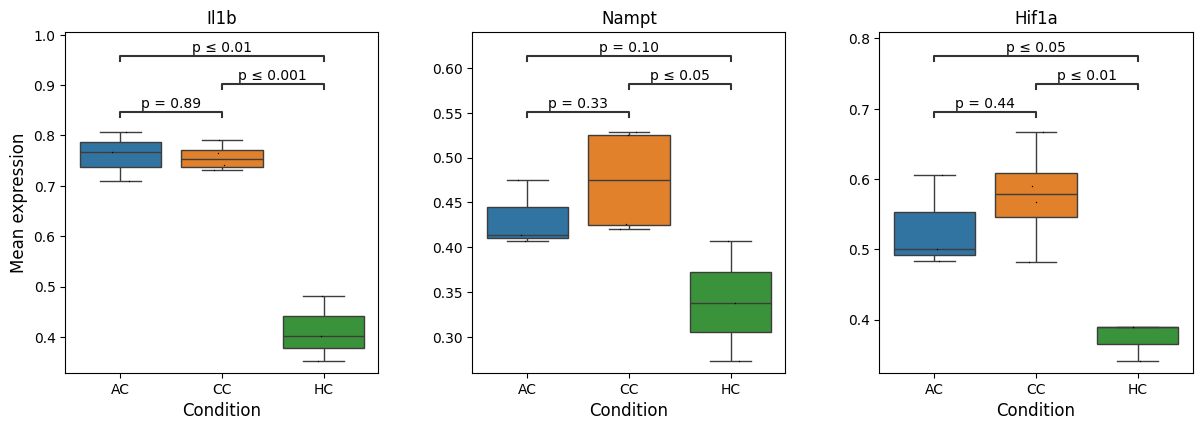

In [ ]:
items_to_plot = ['Il1b', 'Nampt', 'Hif1a']

plot_pct_box(df_all[items_to_plot],
             sample_group_map, ylabel = 'Mean expression',
             ncols = 3, figsize = (4,4), dpi = 100,
             title = None, title_y_pos = 1.05, title_fs = 14,
             label_fs = 12, tick_fs = 10, xtick_rot = 0, xtick_ha = 'center',
             annot_ref = None, annot_fmt = 'simple', annot_fs = 10,
             ws_hs = (0.3, 0.35), stripplot = True)

### __E. Gene Set Aanalysis results__
#### __E.1 Structure and format of the GSA/GSEA results__

In [ ]:
gsa_res_up = adata_t.uns['GSA_vs_ref_up']
gsa_res_dn = adata_t.uns['GSA_vs_ref_down']

list(gsa_res_up.keys())

['B cell',
 'Endothelial cell',
 'Epithelial cell',
 'Fibroblast',
 'ILC',
 'Macrophage',
 'Plasma cell',
 'Smooth muscle cell',
 'T cell CD4+']

##### __Structure of the GSA/GSEA results__

<div>
<img src="https://drive.google.com/uc?export=view&id=1RrmkpkWCI1rcfW5cIBfKvip-lX3lkJRL" align="center" width="500"/>
</div>

<div>
<img src=attachment:1369afc9-25a8-4811-bc55-41e7c61309af.png width="500"/>   
</div>

In [ ]:
gsa_res = gsa_res_up
target_cell = 'Macrophage'

gsa_keys = list(gsa_res[target_cell].keys())
list(gsa_keys)

['AC_vs_HC', 'CC_vs_HC', 'HC_vs_others']

##### __Format of a GSA result__

In [ ]:
gsa_res[target_cell][gsa_keys[2]].head()

pval  pval_adj  \
AGE-RAGE signaling pathway in diabetic complica...  8.786714e-07  0.018085   
Adherens junction                                   2.912050e-02  1.000000   
Amino sugar and nucleotide sugar metabolism         2.075288e-02  1.000000   
Amoebiasis                                          6.510796e-04  1.000000   
Amphetamine addiction                               1.554512e-03  1.000000   

                                                                                                genes  \
AGE-RAGE signaling pathway in diabetic complica...  Ccl2;Ccnd1;Egr1;Col1a2;Plcb4;Tnf;Ccl12;Tgfbr1;...   
Adherens junction                                                  Baiap2;Src;Tgfbr1;Acp1;Cdh1;Tgfbr2   
Amino sugar and nucleotide sugar metabolism                                Npl;Nans;Gnpnat1;Gmds;Hexb   
Amoebiasis                                          Serpinb1a;Col1a2;Hspb1;Muc2;Tnf;Plcb4;Gna15;Se...   
Amphetamine addiction                                         Sirt1;Maoa;Fosb;Arc;Calm2;Jun;Fos;Creb5   

                                                    overlap  pw_size  \
AGE-RAGE signaling pathway in diabetic complica...       15      101   
Adherens junction                                         6       72   
Amino sugar and nucleotide sugar metabolism               5       49   
Amoebiasis                                               11      106   
Amphetamine addiction                                     8       68   

                                                    -log(p-val)  -log(q-val)  \
AGE-RAGE signaling pathway in diabetic complica...     6.056173     1.742686   
Adherens junction                                      1.535801     0.000000   
Amino sugar and nucleotide sugar metabolism            1.682922     0.000000   
Amoebiasis                                             3.186366     0.000000   
Amphetamine addiction                                  2.808406     0.000000   

                                                                                                 Term  \
AGE-RAGE signaling pathway in diabetic complica...  AGE-RAGE signaling pathway in diabetic complic...   
Adherens junction                                                                   Adherens junction   
Amino sugar and nucleotide sugar metabolism               Amino sugar and nucleotide sugar metabolism   
Amoebiasis                                                                                 Amoebiasis   
Amphetamine addiction                                                           Amphetamine addiction   

                                                    Ind  
AGE-RAGE signaling pathway in diabetic complica...    1  
Adherens junction                                     1  
Amino sugar and nucleotide sugar metabolism           1  
Amoebiasis                                            1  
Amphetamine addiction                                 1

#### __E.2 Barplot visualization of condition-specific pathways activity__

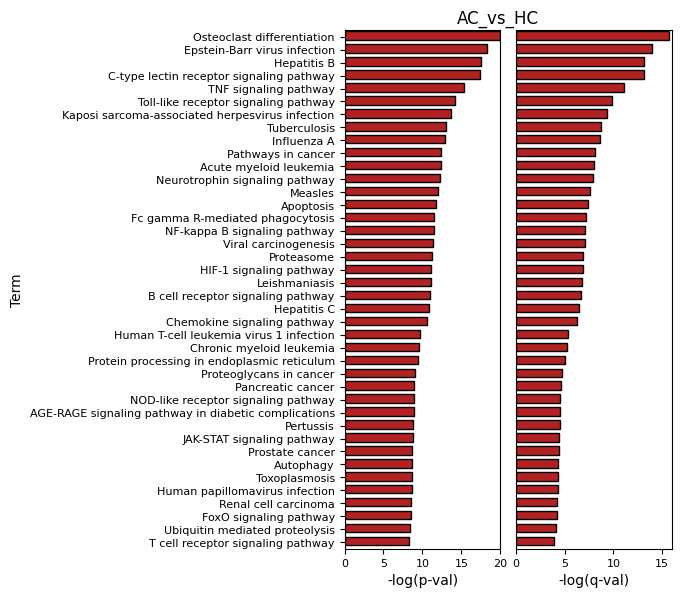

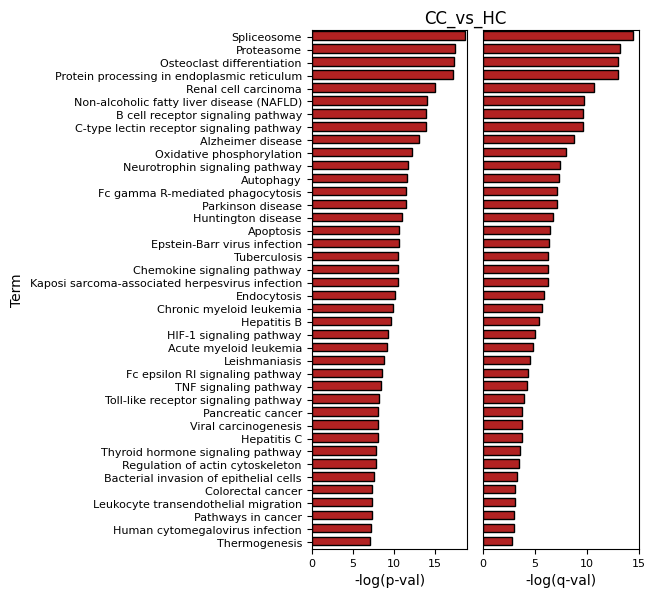

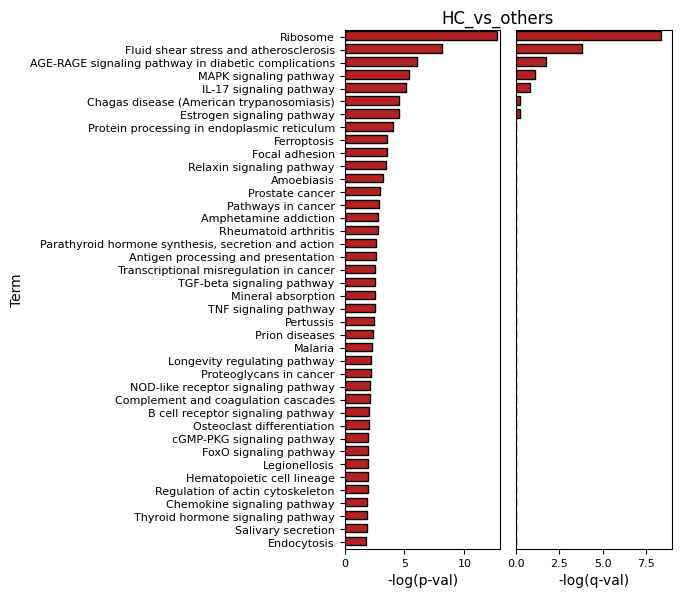

In [ ]:
target_cell = 'Macrophage'

df_gsa_dct = gsa_res[target_cell]

df_sel_dct = plot_gsa_bar( df_gsa_dct, pval_cutoff = 0.05, N_max_to_show = 40,
                  title = None, bar_width = 0.8,
                  title_pos = (0.5, 1), title_fs = 12, title_ha = 'center',
                  label_fs = 10, tick_fs = 8, wspace=0.1, hspace=0.25, Ax = None)

#### __E.3 Dotplot visualization for an overview of condition-specific pathways activity__

In [ ]:
gsa_res = adata_t.uns['GSA_vs_ref_up']
gsa_res.keys()

dict_keys(['B cell', 'Endothelial cell', 'Epithelial cell', 'Fibroblast', 'ILC', 'Macrophage', 'Plasma cell', 'Smooth muscle cell', 'T cell CD4+'])

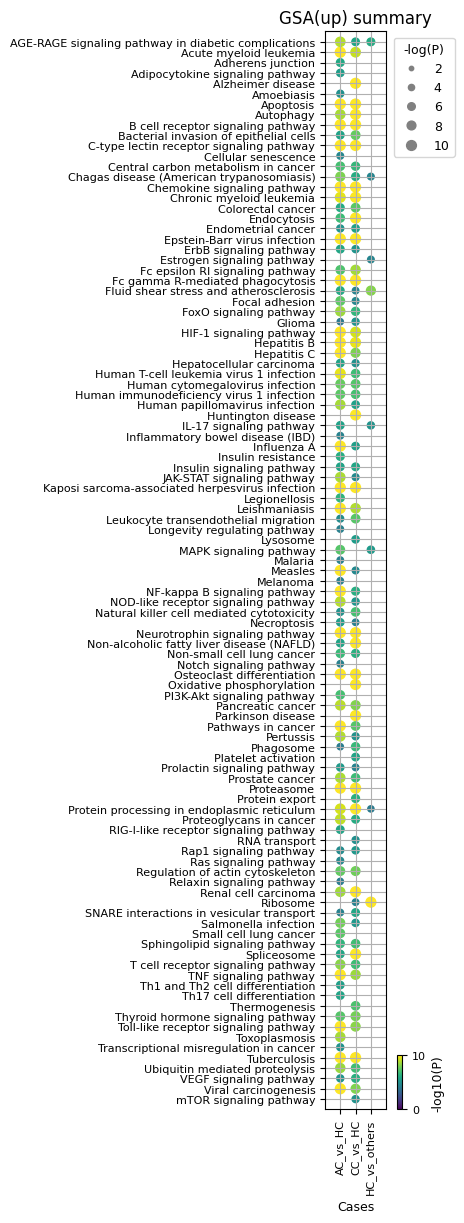

In [ ]:
key = 'Macrophage'
gsa_res_t = gsa_res[key]

plot_gsa_dot( gsa_res_t, pval_cutoff = 1e-4, title = 'GSA(up) summary', title_fs = 12,
              tick_fs = 8, xtick_rot = 90, xtick_ha = 'center',
              label_fs = 9, legend_fs = 9, swap_ax = False, figsize = (1,14),
              dpi = 100, dot_size = 50, cbar_frac = 0.1, cbar_aspect = 10, cmap = 'viridis' )

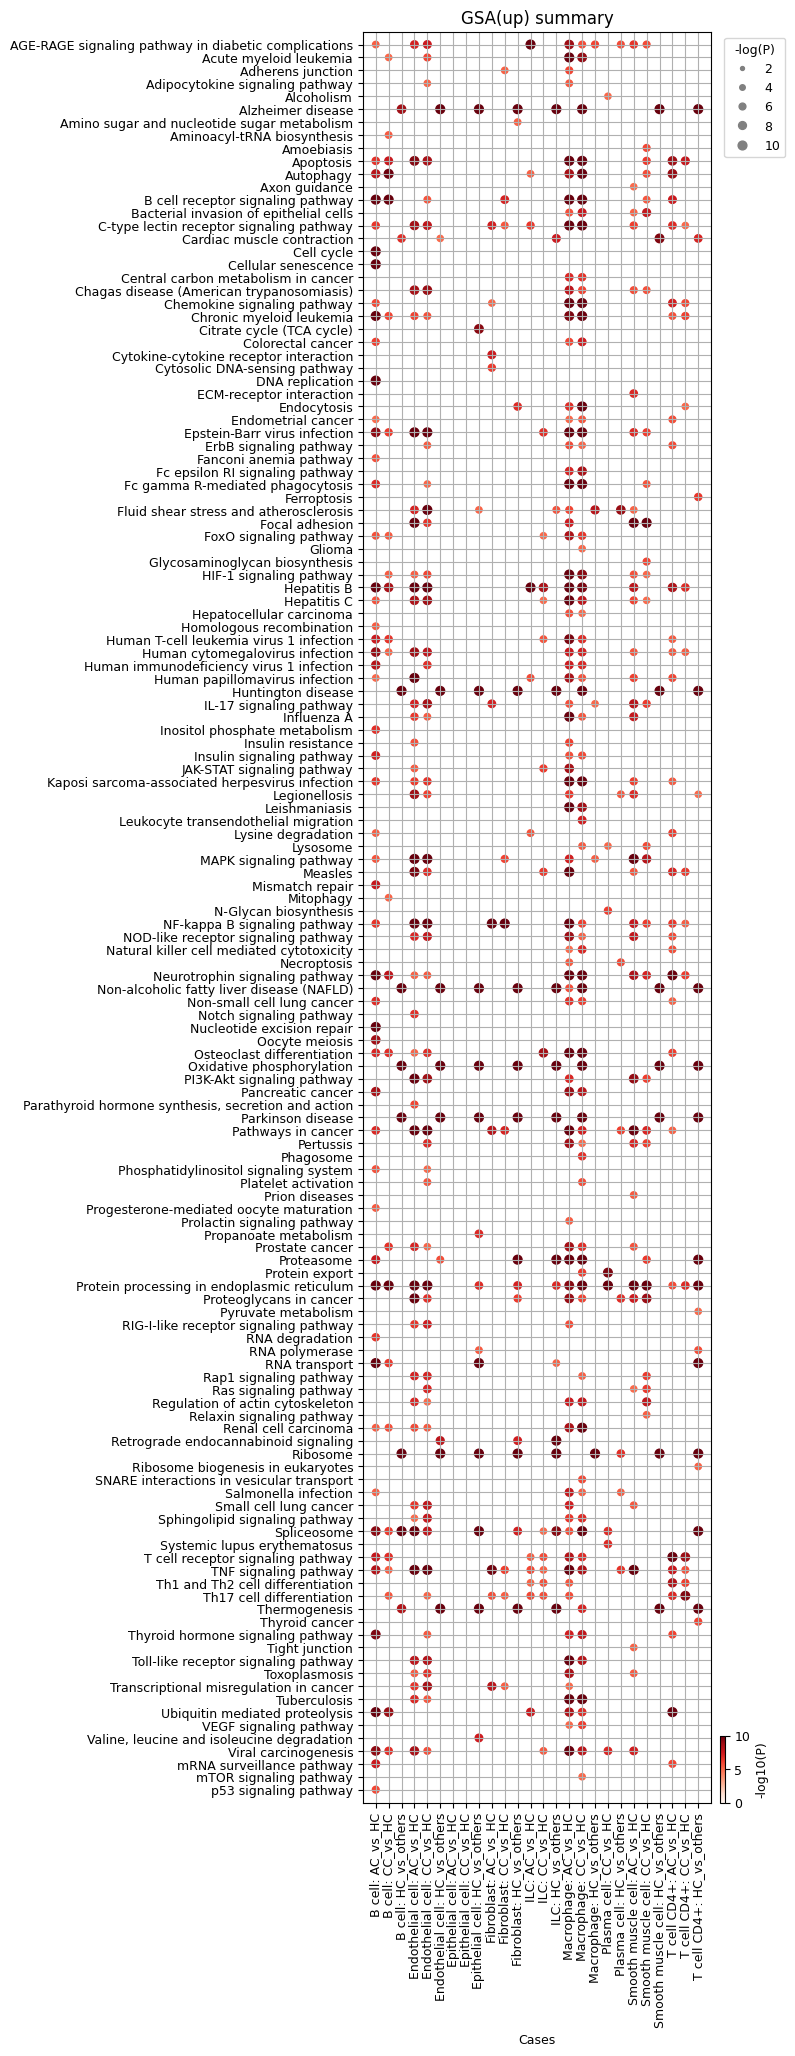

In [ ]:
plot_gsa_dot( gsa_res, pval_cutoff = 1e-5, title = 'GSA(up) summary',
              title_fs = 12, tick_fs = 9, xtick_rot = 90, xtick_ha = 'center',
              label_fs = 9, legend_fs = 9, swap_ax = False, figsize = None,
              dpi = 100, dot_size = 40, cbar_frac = 0.05, cbar_aspect = 15,
              cmap = 'Reds' )

### __F. GSEA results__
#### Data structure and format are the same as those for GSA results

In [ ]:
gsea_res = adata_t.uns['GSEA_vs_ref']
list(gsea_res.keys())

['B cell',
 'Endothelial cell',
 'Epithelial cell',
 'Fibroblast',
 'ILC',
 'Macrophage',
 'Plasma cell',
 'Smooth muscle cell',
 'T cell CD4+']

In [ ]:
target_cell = 'Macrophage'

gsea_keys = list(gsea_res[target_cell].keys())
list(gsea_keys)

['AC_vs_HC', 'CC_vs_HC', 'HC_vs_others']

#### __F.1 Barplot visualization of condition-specific pathways activity__

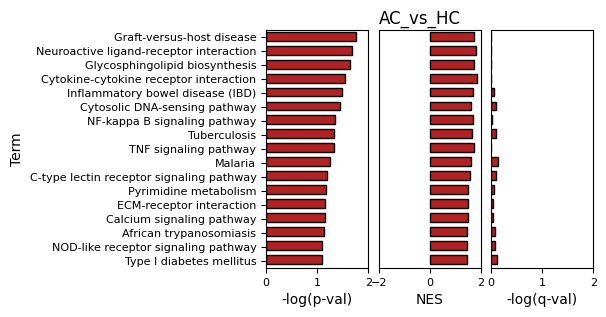

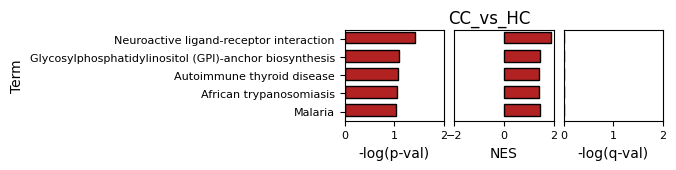

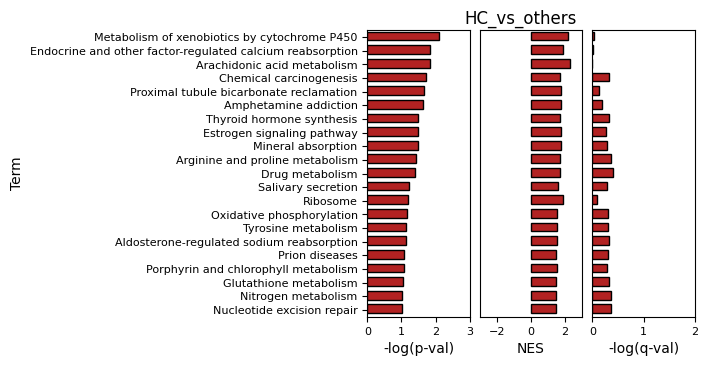

In [ ]:
target_cell = 'Macrophage'
# target_cell = 'Aneuploid Epithelial cell'
df_gsea_dct = gsea_res[target_cell]

df_sel_dct = plot_gsa_bar( df_gsea_dct, pval_cutoff = 1e-1,
                  nes_cutoff = 0, N_max_to_show = 50,
                  title = None, bar_width = 0.8,
                  title_pos = (0.5, 1), title_fs = 12, title_ha = 'center',
                  label_fs = 10, tick_fs = 8, wspace=0.1, hspace=0.25, Ax = None)

#### __F.2 Dotplot visualization for an overview of condition-specific pathways activity__

In [ ]:
gsea_res.keys()

dict_keys(['B cell', 'Endothelial cell', 'Epithelial cell', 'Fibroblast', 'ILC', 'Macrophage', 'Plasma cell', 'Smooth muscle cell', 'T cell CD4+'])

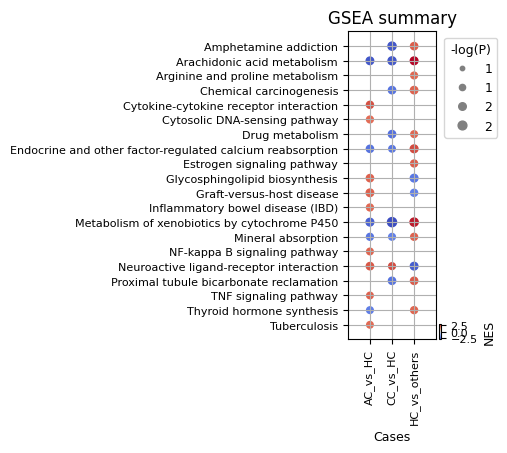

In [ ]:
# target_cell = 'Aneuploid Epithelial cell'
target_cell = 'Macrophage'

gsea_res_t = gsea_res['Macrophage']
pval_cutoff = 0.05

plot_gsa_dot( gsea_res_t, pval_cutoff = pval_cutoff,
              title = 'GSEA summary', title_fs = 12,
              tick_fs = 8, xtick_rot = 90, xtick_ha = 'center',
              label_fs = 9, legend_fs = 9, swap_ax = False, figsize = (1.2,4),
              dpi = 100, dot_size = 50, cbar_frac = 0.1, cbar_aspect = 10,
              cmap = 'coolwarm' )

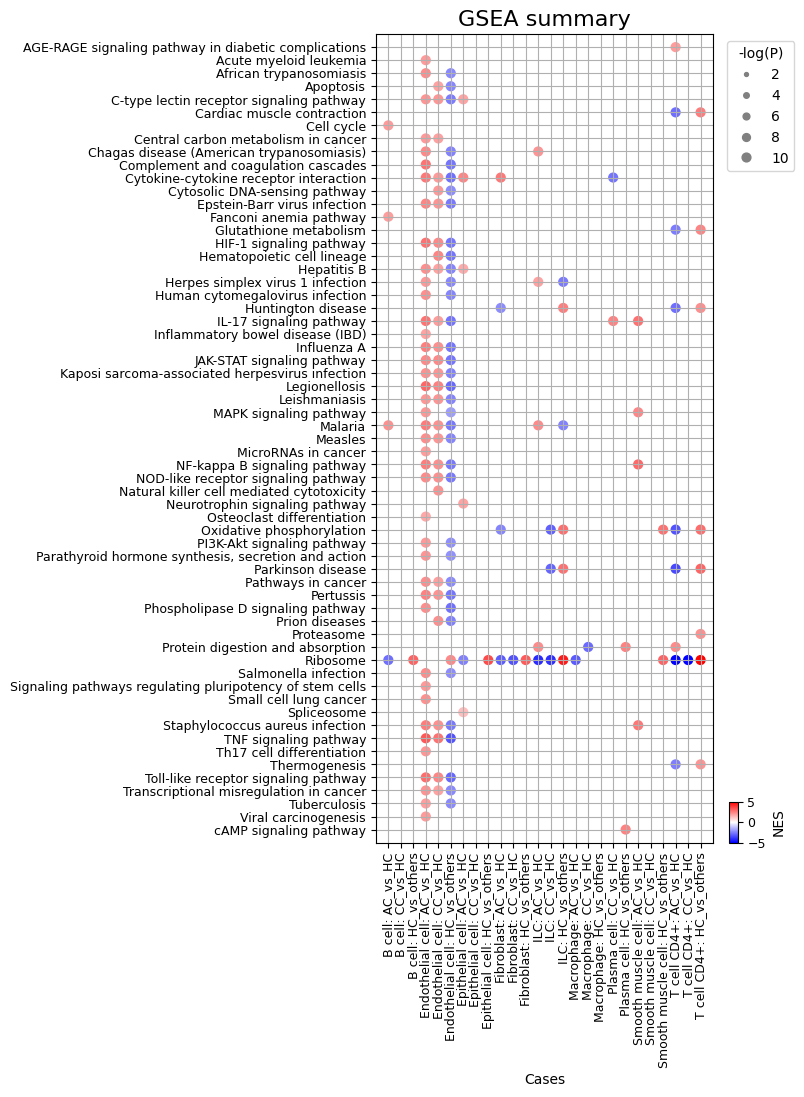

In [ ]:
plot_gsa_dot( gsea_res, pval_cutoff = 1e-4,
              title = 'GSEA summary', title_fs = 16,
              tick_fs = 9, xtick_rot = 90, xtick_ha = 'center',
              label_fs = 10, legend_fs = 10, swap_ax = False,
              figsize = None, dpi = 100, dot_size = 40,
              cbar_frac = 0.2, cbar_aspect = 5, cmap = 'bwr' )